#### Dependencies

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from hmmlearn.hmm import GaussianHMM
from tqdm import tqdm
import seaborn as sns
from scipy.stats import chisquare
import sys
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib as mpl
import joblib
from sklearn.model_selection import KFold
from matplotlib.colors import LogNorm
from scipy.interpolate import PchipInterpolator
from scipy.stats import ttest_ind
from scipy.stats import linregress
import warnings
import matplotlib.cm as cm
import os


np.random.seed(42)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
plt.rcParams.update({
    'font.family': 'Arial',       # Set default font to Arial
    'font.size': 12,               # Set default font size to 2
    'figure.figsize': (4, 4),     # Set default figure size to 4x4 inches
    'axes.labelweight': 'bold',   # Make axis labels bold
    'axes.titleweight': 'bold',   # Make title bold
    'axes.titlesize': 12,          # Set title size to 2
    'axes.labelsize': 12,          # Set axis label size to 2
    'xtick.labelsize': 12,         # Set x-tick label size to 2
    'ytick.labelsize': 12,         # Set y-tick label size to 2
    'xtick.major.width': 0.9,     # Increase tick width
    'ytick.major.width': 0.9,     # Increase tick width
    'xtick.major.size': 3,        # Increase tick size
    'ytick.major.size': 3,        # Increase tick size
    'axes.linewidth': 1.1,        # Set axis line width
    'font.weight': 'bold',        # Make all text bold
})

mpl.rcParams['pdf.fonttype'] = 42

#### Functions

##### File formatting

In [4]:
def smooth_and_shift_trace(df, start_time, end_time, window_size=20000, target_intercept=12.00):
    # Assuming your DataFrame is already loaded as df (df['time (seconds)'], df['force (pN)'])
    time = df['time (seconds)'].values
    force = df['force (pN)'].values

    # Step 1: Apply extreme smoothing to the force data
    force_smooth = pd.Series(force).rolling(window=window_size, min_periods=1, center=True).mean().values

    # Step 2: Select the range of the trace for fitting
    mask = (time >= start_time) & (time <= end_time)
    time_fit = time[mask]
    force_smooth_fit = force_smooth[mask]

    # Step 3: Fit a linear line (linear regression) to the smoothed data in the selected range
    slope, intercept = np.polyfit(time_fit, force_smooth_fit, 1)

    # Step 4: Calculate the linear drift component using the fitted line from the selected range
    fitted_line_fit_range = slope * time_fit + intercept

    # Step 5: Shift the entire force trace so that the fitted line intercepts at the target intercept (e.g., 12.00)
    intercept_adjustment = target_intercept - intercept
    force_corrected = force + intercept_adjustment

    # Step 6: Refit the corrected data to check the new slope and intercept (over the fitting range only)
    final_corrected_slope, final_corrected_intercept = np.polyfit(time_fit, force_corrected[mask], 1)
    corrected_fitted_line_fit_range = final_corrected_slope * time_fit + final_corrected_intercept

    # Step 7: Plot the original force data, smoothed data, the fitted line in the fit range, and the corrected force data
    fig, ax = plt.subplots(3, 1, figsize=(6, 7))

    # Plot the original force data and smoothed data
    ax[0].plot(time, force, label="Original Force", color='lightsteelblue', alpha=1)
    ax[0].plot(time, force_smooth, label=f"Smoothed Force (window={window_size})", color='black', lw=1.5)
    #ax[0].set_title("Original Force with Smoothing")
    ax[0].set_xlabel('Time (seconds)')
    ax[0].set_ylabel('Force (pN)')
    ax[0].set_ylim(8,15)
    #ax[0].set_xlim(75,160)
    ax[0].legend(frameon=False)

    # Plot the fitted line only within the selected fitting range
    ax[1].plot(time, force, label="Original Force", color='lightsteelblue', alpha=1)
    ax[1].plot(time_fit, fitted_line_fit_range, label=f"Fitted Line in Fit Range (y = {slope:.3f}x + {intercept:.2f})", color='purple', lw=2)
    ax[1].axvspan(start_time, end_time, color='yellow', alpha=0.2, label="Fit Range")  # Highlight fitting range
    #ax[1].set_title("Linear Fit in Selected Range")
    ax[1].set_xlabel('Time (seconds)')
    ax[1].set_ylabel('Force (pN)')
    ax[1].set_ylim(8,15)
    #ax[1].set_xlim(75,160)
    ax[1].legend(frameon=False)


    # Plot the corrected force data over the entire trace with the final fit (zero slope and intercept at target intercept)
    ax[2].plot(time, force_corrected, label=f"Corrected Force (Intercept at {target_intercept})", color='lightgrey')
    ax[2].plot(time, np.full_like(time, target_intercept), label=f"Expected Baseline (y = {target_intercept})", color='purple', lw=2, linestyle='--')
    #ax[2].set_title("Corrected Force over Entire Trace")
    ax[2].set_xlabel('Time (seconds)')
    ax[2].set_ylabel('Force (pN)')
    ax[2].set_ylim(8,15)
    #ax[2].set_xlim(75,160)
    ax[2].legend(frameon=False)


    # # Plot the corrected data fit in the same fitting range to confirm zero slope
    # ax[3].plot(time_fit, force_corrected[mask], label="Corrected Force (Fit Range)", color='blue', alpha=0.5)
    # ax[3].plot(time_fit, corrected_fitted_line_fit_range, label=f"Fit to Corrected Data (y = {final_corrected_slope:.3f}x + {final_corrected_intercept:.2f})", color='purple', lw=2)
    # ax[3].axhline(target_intercept, color='orange', linestyle='--', label=f"Target Intercept at {target_intercept}")
    # ax[3].set_title("Fit to Corrected Data in Fit Range (Expecting Zero Slope)")
    # ax[3].set_xlabel('Time (seconds)')
    # ax[3].set_ylabel('Force (pN)')
    # ax[3].legend()

    #plt.suptitle(f'Force Over Time with Linear Drift Correction (Intercept at {target_intercept})')
    plt.tight_layout()
    plt.savefig('/Users/emily/Desktop/output.pdf', format='pdf')
    plt.show()

    # Optionally: Add the corrected force data back into the DataFrame
    df['force_corrected (pN)'] = force_corrected

    return df

def linear_correction(df, window_size=5000):
    # Assuming your DataFrame is already loaded as df (df['time (seconds)'], df['force (pN)'])
    time = df['time (seconds)'].values
    force = df['force (pN)'].values

    # Step 1: Apply a rolling window to smooth the force data
    force_smooth = pd.Series(force).rolling(window=window_size, min_periods=1, center=True).mean().values

    # Step 2: Fit a linear line (linear regression) to the smoothed data
    slope, intercept = np.polyfit(time, force_smooth, 1)

    # Step 3: Calculate the linear drift component using the fitted line from smoothed data
    fitted_line = slope * time + intercept

    # Step 4: Correct the original force data (not the smoothed one) while keeping the intercept at 12
    initial_force_corrected = force[0]  # Starting force value of the original data
    force_corrected = force - (fitted_line - initial_force_corrected)

    # Step 5: Adjust the corrected force data so that its fitted line has an intercept at exactly 12
    corrected_slope, corrected_intercept = np.polyfit(time, force_corrected, 1)
    intercept_adjustment = 12.00 - corrected_intercept
    force_corrected += intercept_adjustment

    # Step 6: Refit the corrected data to check the new intercept
    final_corrected_slope, final_corrected_intercept = np.polyfit(time, force_corrected, 1)
    corrected_fitted_line = final_corrected_slope * time + final_corrected_intercept

    # Step 7: Plot the original force data, smoothed data, the fitted linear trend, and the corrected force data
    fig, ax = plt.subplots(3, 1, figsize=(6, 7))

    # Plot the original force data
    ax[0].plot(time, force, label="Original force", color='lightsteelblue', alpha=1)

    # Plot the smoothed force data
    ax[0].plot(time, force_smooth, label=f"Smoothed force", color='black', lw=1.5)

    # Plot the fitted linear trend
    ax[1].plot(time, force, label="Original force", color='lightsteelblue', alpha=1)
    ax[1].plot(time, fitted_line, label=f"Linear fit (y = {slope:.3f}x + {intercept:.2f})", color='purple', lw=2, linestyle='--')

    # Plot the corrected force data with its final fit
    ax[2].plot(time, force_corrected, label="Corrected force", color='lightgrey', alpha=1)
    ax[2].plot(time, corrected_fitted_line, label=f"Linear fit (y = {final_corrected_slope:.3f}x + {final_corrected_intercept:.2f})", color='purple', lw=2, linestyle='--')

    # Customize the plots
    ax[0].set_xlabel('Time (seconds)')
    ax[0].set_ylabel('Force (pN)')
    ax[0].set_ylim(8,15)
    ax[0].set_xlim(10,200)
    ax[0].legend(frameon=False)

    ax[1].set_xlabel('Time (seconds)')
    ax[1].set_ylabel('Force (pN)')
    ax[1].set_ylim(8,15)
    ax[1].set_xlim(10,200)
    ax[1].legend(frameon=False)

    ax[2].set_xlabel('Time (seconds)')
    ax[2].set_ylabel('Force (pN)')
    ax[2].set_ylim(8,15)
    ax[2].set_xlim(10,200)
    ax[2].legend(frameon=False)

    #plt.suptitle('Force Over Time with Linear Drift Correction Using Smoothed Data')
    plt.tight_layout()
    plt.savefig('/Users/emily/Desktop/output.pdf', format='pdf')
    plt.show()

    # Optionally: Add the corrected force data back into the DataFrame
    df['force_corrected (pN)'] = force_corrected

    return df

In [5]:
def linear_correction(df, window_size=5000):
    # Assuming your DataFrame is already loaded as df (df['time (seconds)'], df['force (pN)'])
    time = df['time (seconds)'].values
    force = df['force (pN)'].values

    # Step 1: Apply a rolling window to smooth the force data
    force_smooth = pd.Series(force).rolling(window=window_size, min_periods=1, center=True).mean().values

    # Step 2: Fit a linear line (linear regression) to the smoothed data
    slope, intercept = np.polyfit(time, force_smooth, 1)

    # Step 3: Calculate the linear drift component using the fitted line from smoothed data
    fitted_line = slope * time + intercept

    # Step 4: Correct the original force data (not the smoothed one) while keeping the intercept at 12
    initial_force_corrected = force[0]  # Starting force value of the original data
    force_corrected = force - (fitted_line - initial_force_corrected)

    # Step 5: Adjust the corrected force data so that its fitted line has an intercept at exactly 12
    corrected_slope, corrected_intercept = np.polyfit(time, force_corrected, 1)
    intercept_adjustment = 12.00 - corrected_intercept
    force_corrected += intercept_adjustment

    # Step 6: Refit the corrected data to check the new intercept
    final_corrected_slope, final_corrected_intercept = np.polyfit(time, force_corrected, 1)
    corrected_fitted_line = final_corrected_slope * time + final_corrected_intercept

    # Step 7: Plot the original force data, smoothed data, the fitted linear trend, and the corrected force data
    fig, ax = plt.subplots(3, 1, figsize=(6, 7))

    # Plot the original force data
    ax[0].plot(time, force, label="Original force", color='lightsteelblue', alpha=1)

    # Plot the smoothed force data
    ax[0].plot(time, force_smooth, label=f"Smoothed force", color='black', lw=1.5)

    # Plot the fitted linear trend
    ax[1].plot(time, force, label="Original force", color='lightsteelblue', alpha=1)
    ax[1].plot(time, fitted_line, label=f"Linear fit (y = {slope:.3f}x + {intercept:.2f})", color='purple', lw=2, linestyle='--')

    # Plot the corrected force data with its final fit
    ax[2].plot(time, force_corrected, label="Corrected force", color='lightgrey', alpha=1)
    ax[2].plot(time, corrected_fitted_line, label=f"Linear fit (y = {final_corrected_slope:.3f}x + {final_corrected_intercept:.2f})", color='purple', lw=2, linestyle='--')

    # Customize the plots
    ax[0].set_xlabel('Time (seconds)')
    ax[0].set_ylabel('Force (pN)')
    ax[0].set_ylim(8,15)
    ax[0].set_xlim(10,200)
    ax[0].legend(frameon=False)

    ax[1].set_xlabel('Time (seconds)')
    ax[1].set_ylabel('Force (pN)')
    ax[1].set_ylim(8,15)
    ax[1].set_xlim(10,200)
    ax[1].legend(frameon=False)

    ax[2].set_xlabel('Time (seconds)')
    ax[2].set_ylabel('Force (pN)')
    ax[2].set_ylim(8,15)
    ax[2].set_xlim(10,200)
    ax[2].legend(frameon=False)

    #plt.suptitle('Force Over Time with Linear Drift Correction Using Smoothed Data')
    plt.tight_layout()
    plt.savefig('/Users/emily/Desktop/output.pdf', format='pdf')
    plt.show()

    # Optionally: Add the corrected force data back into the DataFrame
    df['force_corrected (pN)'] = force_corrected

    return df

##### Statistics

In [6]:
def aic_bic_hmm_states_convergence_minmax(
    traces,
    min_no_states=1,
    max_no_states=6,
    cross_val=False,
    n_splits=1,
    convergence_threshold=0.01,
    max_iter=300,
    n_jobs=-1,
    save_dir="models/hmm_results"
):
    # --- Prepare data & create save directory ---
    combined = np.concatenate([
        t['force_corrected (pN)'].values for t in traces
    ])
    X = combined[~np.isnan(combined)].reshape(-1, 1)
    os.makedirs(save_dir, exist_ok=True)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42) if cross_val else None

    states = list(range(min_no_states, max_no_states + 1))
    aic_vals, bic_vals, ll_vals, ll_ratios = [], [], [], []
    fold_lls = {}
    prev_bic = None
    prev_ll = None

    for n in states:
        print(f"\n▶ Starting fit for {n} states…")

        # Fit HMM
        if cross_val:
            ll_folds, aics, bics = [], [], []
            for fold, (train_i, test_i) in enumerate(kf.split(X), start=1):
                print(f"   • fold {fold}/{n_splits}")
                model = GaussianHMM(
                    n_components=n,
                    covariance_type="full",
                    n_iter=max_iter,
                    tol=convergence_threshold,
                    verbose=True,
                    random_state=42
                ).fit(X[train_i])

                ll = model.score(X[test_i])
                p = n ** 2 + 2 * n * X.shape[1] - 1
                ll_folds.append(ll)
                aics.append(2 * p - 2 * ll)
                bics.append(np.log(len(test_i)) * p - 2 * ll)

            mean_ll = np.mean(ll_folds)
            mean_aic = np.mean(aics)
            mean_bic = np.mean(bics)
            fold_lls[n] = ll_folds

        else:
            # Track log-likelihood at each iteration
            model = GaussianHMM(
                n_components=n,
                covariance_type="full",
                n_iter=max_iter,
                tol=convergence_threshold,
                verbose=True,
                random_state=42
            )
            model.fit(X)

            # Save log-likelihood per iteration
            ll_per_iter = model.monitor_.history
            csv_path = os.path.join(save_dir, f"loglikelihood_{n}_states.csv")
            pd.DataFrame({"iteration": range(1, len(ll_per_iter) + 1),
                          "log_likelihood": ll_per_iter}).to_csv(csv_path, index=False)
            print(f"   Log-likelihood history saved: {csv_path}")

            mean_ll = model.score(X)
            p = n ** 2 + 2 * n * X.shape[1] - 1
            mean_aic = 2 * p - 2 * mean_ll
            mean_bic = np.log(len(X)) * p - 2 * mean_ll
            fold_lls[n] = None

        # Save model
        model_path = os.path.join(save_dir, f"model_{n}_states.pkl")
        joblib.dump(model, model_path)
        print(f"✔ Model saved to {model_path}")

        # Append metrics
        aic_vals.append(mean_aic)
        bic_vals.append(mean_bic)
        ll_vals.append(mean_ll)
        ll_ratios.append(mean_ll - prev_ll if prev_ll is not None else np.nan)
        prev_ll = mean_ll

        print(f"✔ Done {n} states: AIC={mean_aic:.1f}, BIC={mean_bic:.1f}, LL={mean_ll:.1f}")

        # Early stopping on BIC convergence
        if prev_bic is not None:
            diff = abs(prev_bic - mean_bic)
            if diff < convergence_threshold:
                print(f"⏸ BIC improvement {diff:.4f} < threshold "
                      f"{convergence_threshold}, stopping at {n} states.")
                break
        prev_bic = mean_bic

    # Plot results
    fitted_states = states[:len(aic_vals)]

    plt.figure(figsize=(6, 4))
    plt.plot(fitted_states, aic_vals, marker='o', linestyle='--', color='dimgrey', label='AIC')
    plt.plot(fitted_states, bic_vals, marker='o', linestyle='--', color='firebrick', label='BIC')
    plt.xticks(fitted_states)
    plt.xlabel('States'); plt.ylabel('Criterion'); plt.legend(frameon=False)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(fitted_states, ll_vals, marker='o', linestyle='--', color='darkgreen', label='Log-Likelihood')
    plt.xticks(fitted_states)
    plt.xlabel('States'); plt.ylabel('Log-Likelihood'); plt.legend(frameon=False)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(fitted_states, ll_ratios, marker='o', linestyle='--', color='blue', label='LL-Ratio (ΔLL)')
    plt.xticks(fitted_states)
    plt.xlabel('States'); plt.ylabel('Δ Log-Likelihood'); plt.legend(frameon=False)
    plt.tight_layout(); plt.show()

    # Save AIC, BIC, LL summary to CSV
    summary_df = pd.DataFrame({
        "states": fitted_states,
        "AIC": aic_vals,
        "BIC": bic_vals,
        "LogLikelihood": ll_vals,
        "LL_Ratio": ll_ratios
    })
    summary_path = os.path.join(save_dir, "aic_bic_ll_summary.csv")
    summary_df.to_csv(summary_path, index=False)
    print(f"Summary saved to {summary_path}")

    return {
        "aic": aic_vals,
        "bic": bic_vals,
        "ll": ll_vals,
        "ll_ratio": ll_ratios,
        "fold_lls": fold_lls
    }


In [7]:
def aic_bic_hmm_states_convergence_minmax_bp(
    traces,
    min_no_states=1,
    max_no_states=6,
    cross_val=False,
    n_splits=1,
    convergence_threshold=0.01,
    max_iter=300,
    n_jobs=-1,
    save_dir="models/hmm_results"
):
    # --- Prepare data & create save directory ---
    combined = np.concatenate([
        t['bp_corrected'].values for t in traces
    ])
    X = combined[~np.isnan(combined)].reshape(-1, 1)
    os.makedirs(save_dir, exist_ok=True)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42) if cross_val else None

    states = list(range(min_no_states, max_no_states + 1))
    aic_vals, bic_vals, ll_vals, ll_ratios = [], [], [], []
    fold_lls = {}
    prev_bic = None
    prev_ll = None

    for n in states:
        print(f"\n▶ Starting fit for {n} states…")

        # Fit HMM
        if cross_val:
            ll_folds, aics, bics = [], [], []
            for fold, (train_i, test_i) in enumerate(kf.split(X), start=1):
                print(f"   • fold {fold}/{n_splits}")
                model = GaussianHMM(
                    n_components=n,
                    covariance_type="full",
                    n_iter=max_iter,
                    tol=convergence_threshold,
                    verbose=True,
                    random_state=42
                ).fit(X[train_i])

                ll = model.score(X[test_i])
                p = n ** 2 + 2 * n * X.shape[1] - 1
                ll_folds.append(ll)
                aics.append(2 * p - 2 * ll)
                bics.append(np.log(len(test_i)) * p - 2 * ll)

            mean_ll = np.mean(ll_folds)
            mean_aic = np.mean(aics)
            mean_bic = np.mean(bics)
            fold_lls[n] = ll_folds

        else:
            # Track log-likelihood at each iteration
            model = GaussianHMM(
                n_components=n,
                covariance_type="full",
                n_iter=max_iter,
                tol=convergence_threshold,
                verbose=True,
                random_state=42
            )
            model.fit(X)

            # Save log-likelihood per iteration
            ll_per_iter = model.monitor_.history
            csv_path = os.path.join(save_dir, f"loglikelihood_{n}_states.csv")
            pd.DataFrame({"iteration": range(1, len(ll_per_iter) + 1),
                          "log_likelihood": ll_per_iter}).to_csv(csv_path, index=False)
            print(f"   Log-likelihood history saved: {csv_path}")

            mean_ll = model.score(X)
            p = n ** 2 + 2 * n * X.shape[1] - 1
            mean_aic = 2 * p - 2 * mean_ll
            mean_bic = np.log(len(X)) * p - 2 * mean_ll
            fold_lls[n] = None

        # Save model
        model_path = os.path.join(save_dir, f"model_{n}_states.pkl")
        joblib.dump(model, model_path)
        print(f"✔ Model saved to {model_path}")

        # Append metrics
        aic_vals.append(mean_aic)
        bic_vals.append(mean_bic)
        ll_vals.append(mean_ll)
        ll_ratios.append(mean_ll - prev_ll if prev_ll is not None else np.nan)
        prev_ll = mean_ll

        print(f"✔ Done {n} states: AIC={mean_aic:.1f}, BIC={mean_bic:.1f}, LL={mean_ll:.1f}")

        # Early stopping on BIC convergence
        if prev_bic is not None:
            diff = abs(prev_bic - mean_bic)
            if diff < convergence_threshold:
                print(f"⏸ BIC improvement {diff:.4f} < threshold "
                      f"{convergence_threshold}, stopping at {n} states.")
                break
        prev_bic = mean_bic

    # Plot results
    fitted_states = states[:len(aic_vals)]

    plt.figure(figsize=(6, 4))
    plt.plot(fitted_states, aic_vals, marker='o', linestyle='--', color='dimgrey', label='AIC')
    plt.plot(fitted_states, bic_vals, marker='o', linestyle='--', color='firebrick', label='BIC')
    plt.xticks(fitted_states)
    plt.xlabel('States'); plt.ylabel('Criterion'); plt.legend(frameon=False)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(fitted_states, ll_vals, marker='o', linestyle='--', color='darkgreen', label='Log-Likelihood')
    plt.xticks(fitted_states)
    plt.xlabel('States'); plt.ylabel('Log-Likelihood'); plt.legend(frameon=False)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(fitted_states, ll_ratios, marker='o', linestyle='--', color='blue', label='LL-Ratio (ΔLL)')
    plt.xticks(fitted_states)
    plt.xlabel('States'); plt.ylabel('Δ Log-Likelihood'); plt.legend(frameon=False)
    plt.tight_layout(); plt.show()

    # Save AIC, BIC, LL summary to CSV
    summary_df = pd.DataFrame({
        "states": fitted_states,
        "AIC": aic_vals,
        "BIC": bic_vals,
        "LogLikelihood": ll_vals,
        "LL_Ratio": ll_ratios
    })
    summary_path = os.path.join(save_dir, "aic_bic_ll_summary.csv")
    summary_df.to_csv(summary_path, index=False)
    print(f"Summary saved to {summary_path}")

    return {
        "aic": aic_vals,
        "bic": bic_vals,
        "ll": ll_vals,
        "ll_ratio": ll_ratios,
        "fold_lls": fold_lls
    }


In [8]:
def HMM_fit_bp(traces, random_state, no_states, no_iterations, savepath, convergence_threshold=0.005):
    np.random.seed(random_state)
    all_force_data = np.concatenate([trace['bp_corrected'].values for trace in traces])

    # Remove any NaN values from the combined force data
    valid_indices = ~np.isnan(all_force_data)
    all_force_data = all_force_data[valid_indices]

    all_time_data = []
    for trace in traces:
        time = trace['time'].values
        all_time_data.append(time)
    combined_time = np.concatenate(all_time_data)

    X = all_force_data.reshape(-1, 1)

    # Initialize the HMM with specified number of states and fixed initial parameters
    model = GaussianHMM(n_components=no_states, covariance_type="full", random_state=random_state,
                        tol=convergence_threshold, init_params="")

    model.startprob_ = np.full(no_states, 1.0 / no_states)  # Uniform distribution for initial state probabilities
    model.transmat_ = np.full((no_states, no_states), 1.0 / no_states)  # Uniform transition matrix
    model.means_ = np.linspace(np.min(X), np.max(X), no_states).reshape(-1, 1)  # Spread means across data range
    model.covars_ = np.tile(np.var(X) / no_states, (no_states, 1, 1))  # Covariances for each state

    log_likelihoods = []
    converged = False

    # Custom training loop to monitor convergence
    for i in range(no_iterations):
        model.fit(X)
        log_likelihood = model.score(X)  # Log likelihood of the fitted model
        log_likelihoods.append(log_likelihood)

        # Check for convergence
        if i > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) / abs(log_likelihoods[-2]) < convergence_threshold:
            converged = True
            print(f"Converged at {i + 1} iterations")
            break

    if not converged:
        print(f"Max iterations ({no_iterations}) reached without convergence")

    hidden_states = model.predict(X)

    # Save the model to the specified path
    joblib.dump(model, savepath)
    print(f"Model saved to {savepath}")

    return X, hidden_states, all_time_data, all_force_data, combined_time


In [9]:
def aic_bic_hmm_states_convergence_minmax_firm(
    traces,
    min_no_states=1,
    max_no_states=6,
    cross_val=False,          # NOTE: CV not supported in this refactor (see comment)
    n_splits=1,
    convergence_threshold=0.01,
    max_iter=300,
    n_jobs=-1,
    save_dir="models/hmm_results",
    feature_col='force_corrected (pN)',  # keep your current default
    refit_tol=1e-4,          # stricter tol for final refit
    refit_iter=1000,         # more EM steps for final refit
    sticky_diag=0.7          # diagonal prior for persistence in transitions
):
    """
    Sweep K with AIC/BIC, log progress, and then refit the best-K model with stricter settings.
    Saves:
      - model_{K}_states.pkl for each K during sweep
      - final_model_{bestK}_states.pkl for the final refit
      - loglikelihood_{K}_states.csv per K (EM history)
      - aic_bic_ll_summary.csv

    Returns a dict with metrics + best_K + final_model_path.
    """

    # --- Prepare data & create save directory ---
    os.makedirs(save_dir, exist_ok=True)

    # Build X and lengths to prevent cross-trace transitions
    X_list, lengths = [], []
    for t in traces:
        arr = t[feature_col].to_numpy()
        arr = arr[~np.isnan(arr)]
        if len(arr) == 0:
            continue
        X_list.append(arr)
        lengths.append(len(arr))
    if len(X_list) == 0:
        raise ValueError("No valid data after NaN removal.")
    X = np.concatenate(X_list).reshape(-1, 1)

    # (Optional) CV is non-trivial with sequence lengths; disable here to avoid leakage
    if cross_val:
        raise NotImplementedError("cross_val=True is not supported in this version because proper fold "
                                  "handling with sequence lengths requires segment-aware splitting.")

    states = list(range(min_no_states, max_no_states + 1))
    aic_vals, bic_vals, ll_vals, ll_ratios = [], [], [], []
    prev_bic = None
    prev_ll = None
    fold_lls = {}  # kept for API compatibility; set to None per K
    perK_model_paths = []

    for n in states:
        print(f"\n▶ Starting fit for {n} states…")

        # Neutral but slightly sticky transitions help stability
        trans = np.full((n, n), (1.0 - sticky_diag) / (n - 1))
        np.fill_diagonal(trans, sticky_diag)

        # Means spread across the data range; diag covars are 1D (shape (n, n_features))
        xmin, xmax = np.min(X), np.max(X)

        model = GaussianHMM(
            n_components=n,
            covariance_type="diag",        # faster/sufficient for 1D
            n_iter=max_iter,
            tol=convergence_threshold,
            verbose=True,
            random_state=42,
            init_params=""                 # keep our manual inits
        )
        model.startprob_ = np.full(n, 1.0 / n)
        model.transmat_  = trans
        model.means_     = np.linspace(xmin, xmax, n).reshape(-1, 1)
        model.covars_    = np.full((n, 1), np.var(X) / n)

        model.fit(X, lengths)

        # Save EM log-likelihood history
        ll_per_iter = list(model.monitor_.history)
        csv_path = os.path.join(save_dir, f"loglikelihood_{n}_states.csv")
        pd.DataFrame({"iteration": range(1, len(ll_per_iter) + 1),
                      "log_likelihood": ll_per_iter}).to_csv(csv_path, index=False)
        print(f"   Log-likelihood history saved: {csv_path}")

        mean_ll = model.score(X, lengths)

        # parameter count for 1D diag: (n-1) + n(n-1) + n(means) + n(variances) = n^2 + 2n - 1
        p = n**2 + 2*n - 1
        mean_aic = 2 * p - 2 * mean_ll
        mean_bic = np.log(len(X)) * p - 2 * mean_ll
        fold_lls[n] = None

        # Save per-K model
        model_path = os.path.join(save_dir, f"model_{n}_states.pkl")
        joblib.dump(model, model_path)
        perK_model_paths.append(model_path)
        print(f"✔ Model saved to {model_path}")

        # Append metrics
        aic_vals.append(mean_aic)
        bic_vals.append(mean_bic)
        ll_vals.append(mean_ll)
        ll_ratios.append(mean_ll - prev_ll if prev_ll is not None else np.nan)
        prev_ll = mean_ll

        print(f"✔ Done {n} states: AIC={mean_aic:.1f}, BIC={mean_bic:.1f}, LL={mean_ll:.1f}")

        # Early stopping on BIC convergence across K
        if prev_bic is not None:
            diff = abs(prev_bic - mean_bic)
            if diff < convergence_threshold:
                print(f"⏸ BIC improvement {diff:.4f} < threshold "
                      f"{convergence_threshold}, stopping at {n} states.")
                break
        prev_bic = mean_bic

    # --- Pick best K (lowest BIC among fitted Ks) ---
    fitted_states = states[:len(aic_vals)]
    best_idx = int(np.argmin(bic_vals))
    best_K = fitted_states[best_idx]
    print(f"\n🏁 Best K by BIC: {best_K}")

    # --- Plots (same style as yours) ---
    plt.figure(figsize=(6, 4))
    plt.plot(fitted_states, aic_vals, marker='o', linestyle='--', color='dimgrey', label='AIC')
    plt.plot(fitted_states, bic_vals, marker='o', linestyle='--', color='firebrick', label='BIC')
    plt.xticks(fitted_states)
    plt.xlabel('States'); plt.ylabel('Criterion'); plt.legend(frameon=False)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(fitted_states, ll_vals, marker='o', linestyle='--', color='darkgreen', label='Log-Likelihood')
    plt.xticks(fitted_states)
    plt.xlabel('States'); plt.ylabel('Log-Likelihood'); plt.legend(frameon=False)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(fitted_states, ll_ratios, marker='o', linestyle='--', color='blue', label='LL-Ratio (ΔLL)')
    plt.xticks(fitted_states)
    plt.xlabel('States'); plt.ylabel('Δ Log-Likelihood'); plt.legend(frameon=False)
    plt.tight_layout(); plt.show()

    # Save AIC, BIC, LL summary to CSV
    summary_df = pd.DataFrame({
        "states": fitted_states,
        "AIC": aic_vals,
        "BIC": bic_vals,
        "LogLikelihood": ll_vals,
        "LL_Ratio": ll_ratios
    })
    summary_path = os.path.join(save_dir, "aic_bic_ll_summary.csv")
    summary_df.to_csv(summary_path, index=False)
    print(f"Summary saved to {summary_path}")

    # === Final refit at best_K with stricter settings ===
    print(f"\n🔁 Re-fitting final model at K={best_K} with tol={refit_tol}, n_iter={refit_iter} …")

    # Robust init: use quantile-spaced means to reduce outlier influence
    qs = np.linspace(0, 1, best_K)
    means_init = np.quantile(X.ravel(), qs).reshape(-1, 1)

    trans_final = np.full((best_K, best_K), (1.0 - sticky_diag) / (best_K - 1))
    np.fill_diagonal(trans_final, sticky_diag)

    final_model = GaussianHMM(
        n_components=best_K,
        covariance_type="diag",
        n_iter=refit_iter,
        tol=refit_tol,
        verbose=True,
        random_state=123,   # lock a seed for reproducibility
        init_params=""
    )
    final_model.startprob_ = np.full(best_K, 1.0 / best_K)
    final_model.transmat_  = trans_final
    final_model.means_     = means_init
    final_model.covars_    = np.full((best_K, 1), np.var(X) / best_K)

    final_model.fit(X, lengths)
    final_ll = final_model.score(X, lengths)
    print(f"✔ Final model LL={final_ll:.1f} (EM steps: {len(final_model.monitor_.history)})")

    final_model_path = os.path.join(save_dir, f"final_model_{best_K}_states.pkl")
    joblib.dump(final_model, final_model_path)
    print(f"💾 Final model saved to {final_model_path}")

    return {
        "aic": aic_vals,
        "bic": bic_vals,
        "ll": ll_vals,
        "ll_ratio": ll_ratios,
        "fold_lls": fold_lls,
        "fitted_states": fitted_states,
        "best_K": best_K,
        "final_model_path": final_model_path,
        "perK_model_paths": perK_model_paths,
        "summary_csv": summary_path
    }


In [10]:
def fit_final_hmm(
    traces,
    K,
    feature_col='force_corrected (pN)',
    tol=1e-3,
    n_iter=1000,
    sticky_diag=0.7,
    random_state=42,
    save_path=None
):
    """
    Fit a final GaussianHMM with K states using the same logic as the 'firm' refit:
      - uses lengths (no cross-trace transitions)
      - covariance_type='diag'
      - sticky transitions with sticky_diag on the diagonal
      - quantile-spaced mean initialisation
      - init_params='' (manual inits)
    Returns dict with model and metrics; saves model if save_path is provided.
    """

    # --- Build X and lengths ---
    X_list, lengths = [], []
    for t in traces:
        arr = t[feature_col].to_numpy()
        arr = arr[~np.isnan(arr)]
        if len(arr) == 0:
            continue
        X_list.append(arr)
        lengths.append(len(arr))
    if not X_list:
        raise ValueError("No valid data after NaN removal.")
    X = np.concatenate(X_list).reshape(-1, 1)

    # --- Inits matching the 'firm' refit ---
    # Sticky transitions
    if K == 1:
        trans = np.array([[1.0]])
    else:
        off = (1.0 - sticky_diag) / (K - 1)
        trans = np.full((K, K), off)
        np.fill_diagonal(trans, sticky_diag)

    # Quantile-spaced means (robust)
    qs = np.linspace(0, 1, K)
    means_init = np.quantile(X.ravel(), qs).reshape(-1, 1)

    # Diag covars shape (K, 1)
    covars_init = np.full((K, 1), np.var(X) / K)

    # --- Model (same settings) ---
    model = GaussianHMM(
        n_components=K,
        covariance_type="diag",
        n_iter=n_iter,
        tol=tol,
        verbose=True,
        random_state=random_state,
        init_params=""
    )
    model.startprob_ = np.full(K, 1.0 / K)
    model.transmat_  = trans
    model.means_     = means_init
    model.covars_    = covars_init

    # --- Fit & metrics ---
    model.fit(X, lengths)
    ll = model.score(X, lengths)
    p = K**2 + 2*K - 1              # 1D diag param count
    AIC = 2*p - 2*ll
    BIC = np.log(len(X)) * p - 2*ll

    if save_path:
        joblib.dump(model, save_path)

    return {
        "model": model,
        "K": K,
        "log_likelihood": ll,
        "AIC": AIC,
        "BIC": BIC,
        "lengths": lengths,
        "save_path": save_path
    }


### Files

#### PDGFRA

##### DNA vs CTCF

In [ ]:
ctcf = pd.read_csv('/formatted/DNA_vs_CTCF/120824N47_ctcf.csv')
dna = pd.read_csv('/formatted/DNA_vs_CTCF/120824N47_dna.csv')

##### N-term Naked DNA

In [ ]:
dna1 = pd.read_csv('/formatted/DNA/120824N47.csv')
dna2 = pd.read_csv('/formatted/DNA/120824N73.csv')
dna3 = pd.read_csv('/formatted/DNA/120824N75.csv')
dna4 = pd.read_csv('/formatted/DNA/120824N133.csv')
dna5 = pd.read_csv('/formatted/DNA/120824N186.csv')

##### N-term CTCF WT

In [ ]:
p1 = pd.read_csv('/formatted/PDGFRA/Nterm/120824N47.csv')
p2 = pd.read_csv('/formatted/PDGFRA/Nterm/120824N75.csv')
p3 = pd.read_csv('/formatted/PDGFRA/Nterm/120824N184.csv')
p4 = pd.read_csv('/formatted/PDGFRA/Nterm/120824N186.csv')
p5 = pd.read_csv('/formatted/PDGFRA/Nterm/171024N43.csv')
p6 = pd.read_csv('/formatted/PDGFRA/Nterm/171024N51.csv')
p7 = pd.read_csv('/formatted/PDGFRA/Nterm/171024N57.csv')
p8 = pd.read_csv('/formatted/PDGFRA/Nterm/171024N65.csv')
p9 = pd.read_csv('/formatted/PDGFRA/Nterm/171024N66.csv')
p10 = pd.read_csv('/formatted/PDGFRA/Nterm/171024N75.csv')

In [ ]:
p1_bp = pd.read_csv('/formatted/bp/PDGFRA_N_bp_converted_2khz/fixed_intercept/120824N47.csv')
p2_bp = pd.read_csv('/formatted/bp/PDGFRA_N_bp_converted_2khz/fixed_intercept/120824N75.csv')
p3_bp = pd.read_csv('/formatted/bp/PDGFRA_N_bp_converted_2khz/fixed_intercept/120824N184.csv')
p4_bp = pd.read_csv('/formatted/bp/PDGFRA_N_bp_converted_2khz/fixed_intercept/120824N186.csv')

##### C-term CTCF WT

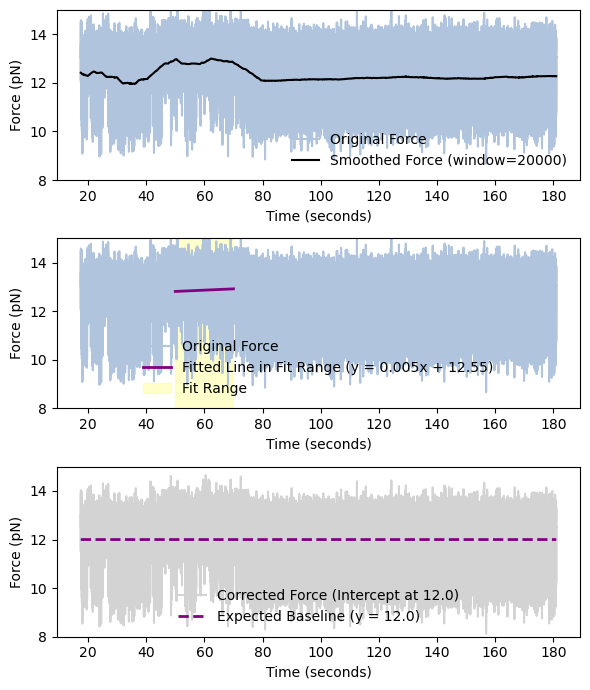

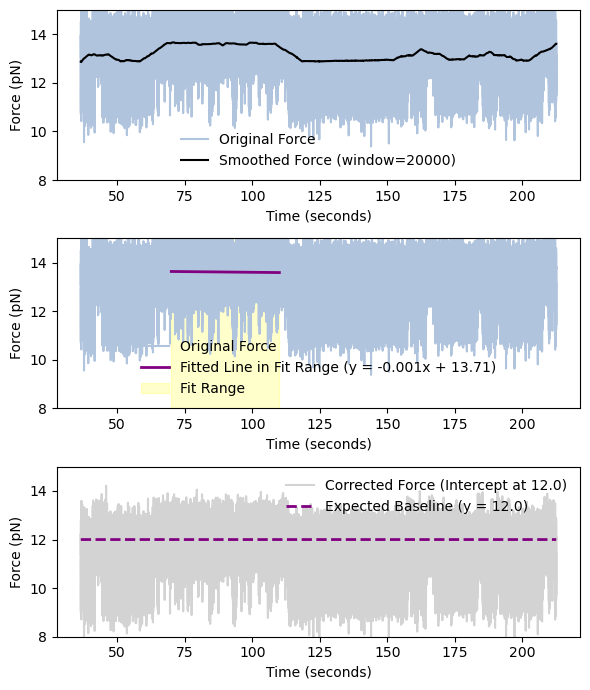

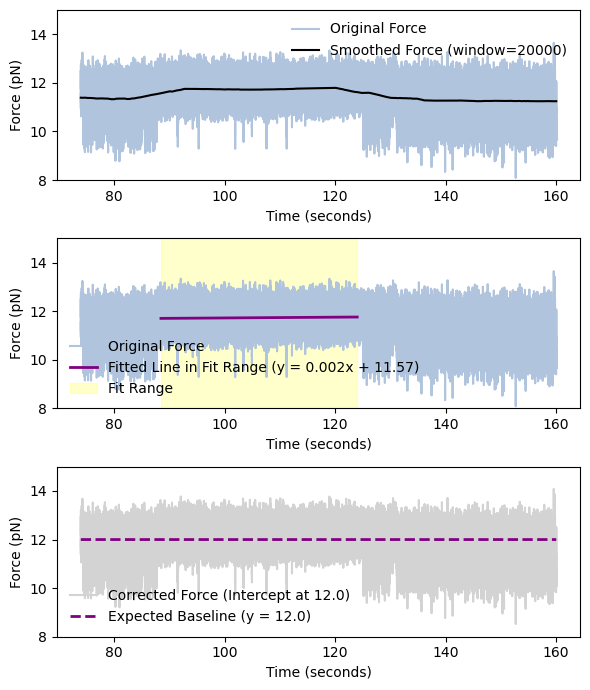

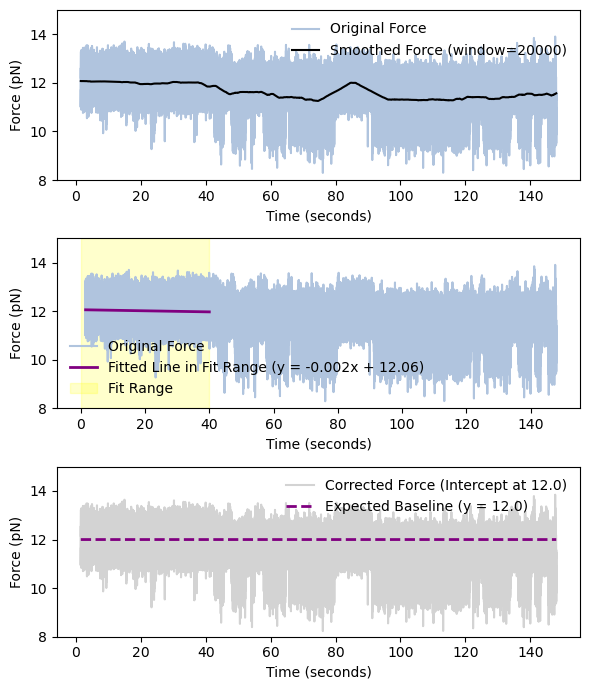

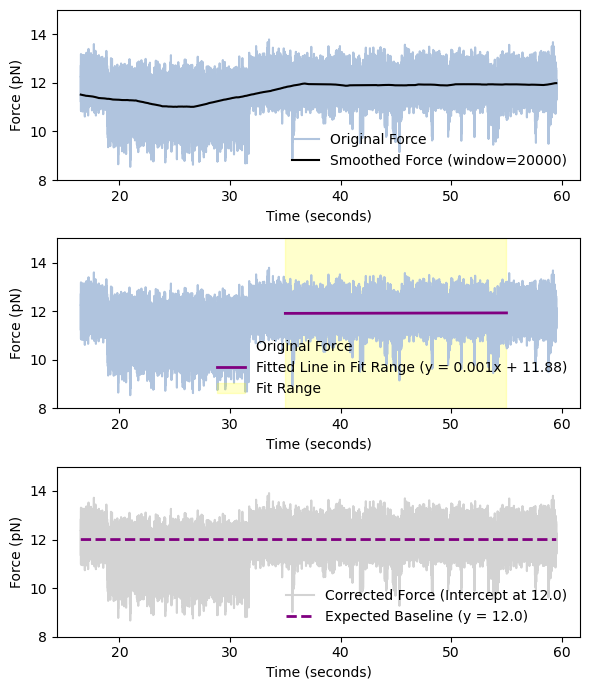

In [ ]:
pc1 = pd.read_csv('/formatted/PDGFRA/Cterm/171024N82.csv')
pc2 = pd.read_csv('/formatted/PDGFRA/Cterm/171024N86.csv')
pc3 = pd.read_csv('/formatted/PDGFRA/Cterm/200824N173.csv')
pc4 = pd.read_csv('/formatted/PDGFRA/Cterm/200824N175.csv')
pc5 = pd.read_csv('/formatted/PDGFRA/Cterm/200824N177.csv')

pc1c = smooth_and_shift_trace(pc1, start_time=50, end_time=70, window_size=20000, target_intercept=12.00)
pc2c = smooth_and_shift_trace(pc2, start_time=70, end_time=110, window_size=20000, target_intercept=12.00)
pc3c = smooth_and_shift_trace(pc3, start_time=88.5, end_time=124, window_size=20000, target_intercept=12.00)
pc4c = smooth_and_shift_trace(pc4, start_time=0, end_time=40, window_size=20000, target_intercept=12.00)
pc5c = smooth_and_shift_trace(pc5, start_time=35, end_time=55, window_size=20000, target_intercept=12.00)

In [ ]:
pc1_bp = pd.read_csv('/formatted/bp/PDGFRA_C_bp_converted_2khz/fixed/171024N82.csv')
pc2_bp = pd.read_csv('/formatted/bp/PDGFRA_C_bp_converted_2khz/fixed/171024N86.csv')
pc3_bp = pd.read_csv('/formatted/bp/PDGFRA_C_bp_converted_2khz/fixed/200824N173.csv')
pc4_bp = pd.read_csv('/formatted/bp/PDGFRA_C_bp_converted_2khz/fixed/200824N177.csv')

##### N-term CTCF DeltaN

In [ ]:
pdn1 = pd.read_csv('/formatted/PDGFRA/Nterm_deltaN/241022N62.csv')
pdn2 = pd.read_csv('/formatted/PDGFRA/Nterm_deltaN/241022N99.csv')
pdn3 = pd.read_csv('/formatted/PDGFRA/Nterm_deltaN/241022N113.csv')
pdn4 = pd.read_csv('/formatted/PDGFRA/Nterm_deltaN/241022N127.csv')
pdn5 = pd.read_csv('/formatted/PDGFRA/Nterm_deltaN/241022N151.csv')

##### C-term CTCF Nucleosome

In [ ]:
n1 = pd.read_csv('/formatted/PDGFRA/Cterm_Nuc/110924N322.csv')
n2 = pd.read_csv('/formatted/PDGFRA/Cterm_Nuc/110924N328.csv')
n3 = pd.read_csv('/formatted/PDGFRA/Cterm_Nuc/110924N328_2.csv')
n4 = pd.read_csv('/formatted/PDGFRA/Cterm_Nuc/110924N330.csv')
n5 = pd.read_csv('/formatted/PDGFRA/Cterm_Nuc/110924N337.csv')
n6 = pd.read_csv('/formatted/PDGFRA/Cterm_Nuc/110924N339.csv')
n7 = pd.read_csv('/formatted/PDGFRA/Cterm_Nuc/110924N341.csv')
n8 = pd.read_csv('/formatted/PDGFRA/Cterm_Nuc/110924N343.csv')
n9 = pd.read_csv('/formatted/PDGFRA/Cterm_Nuc/110924N360.csv')

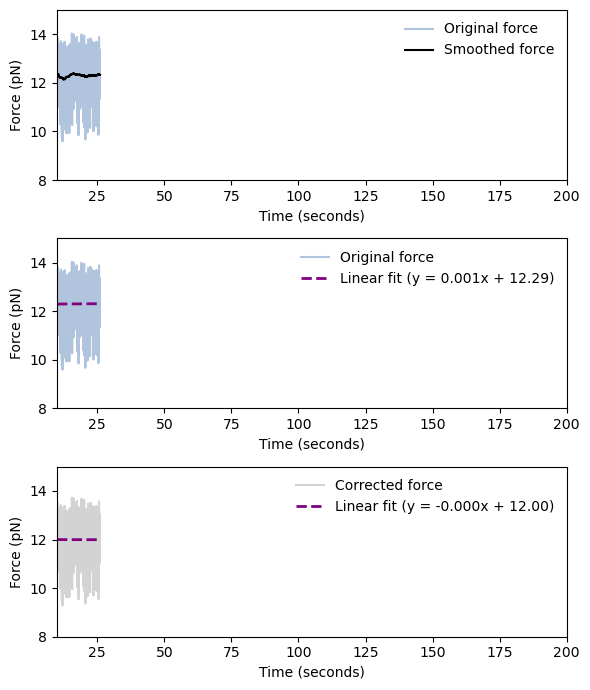

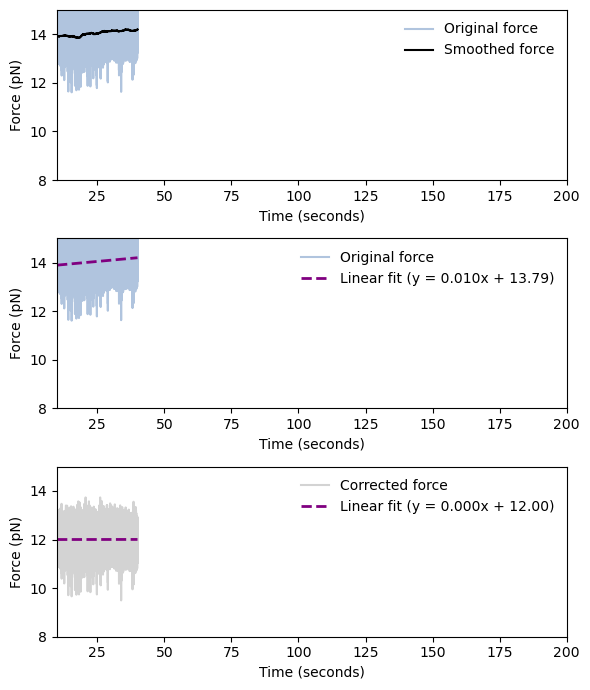

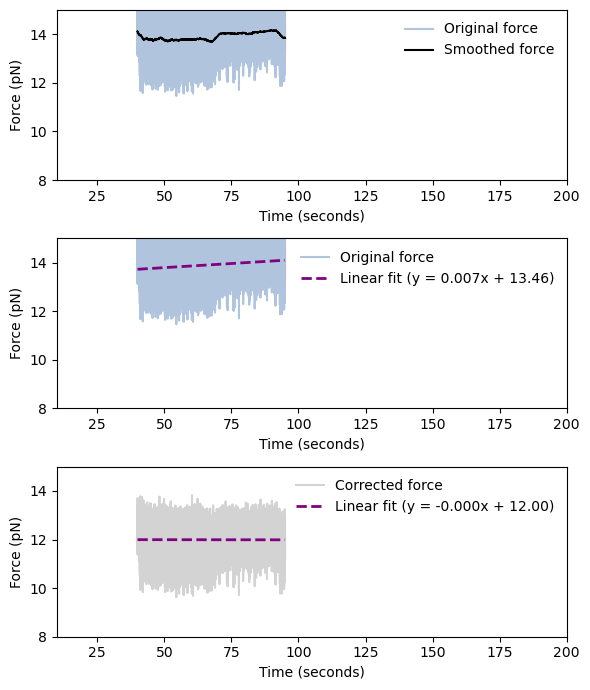

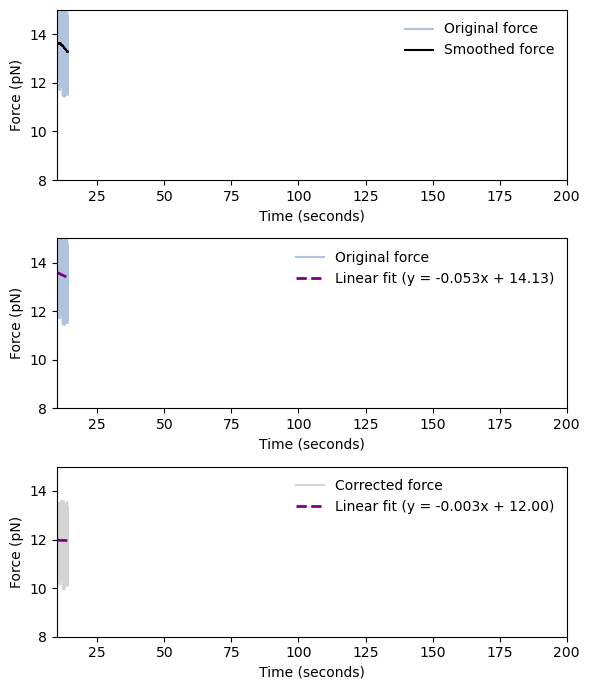

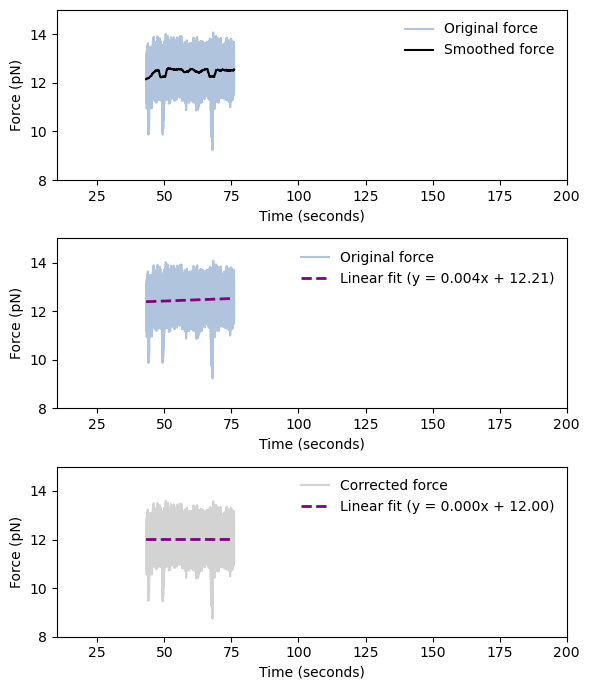

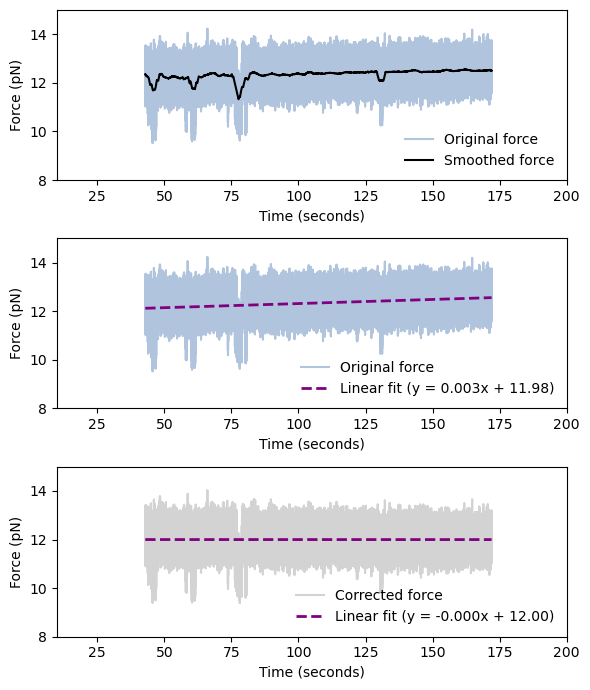

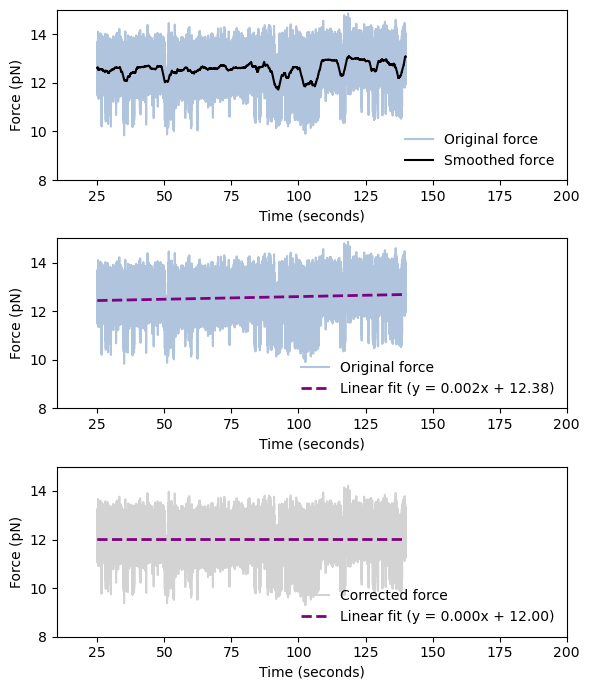

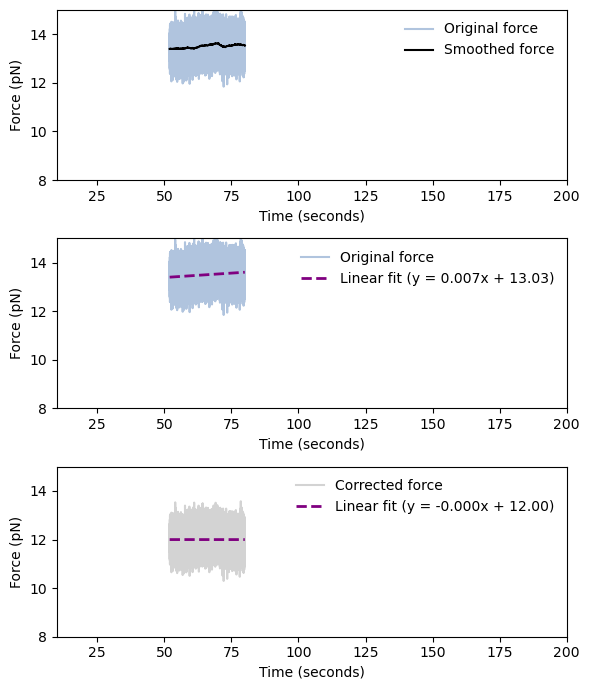

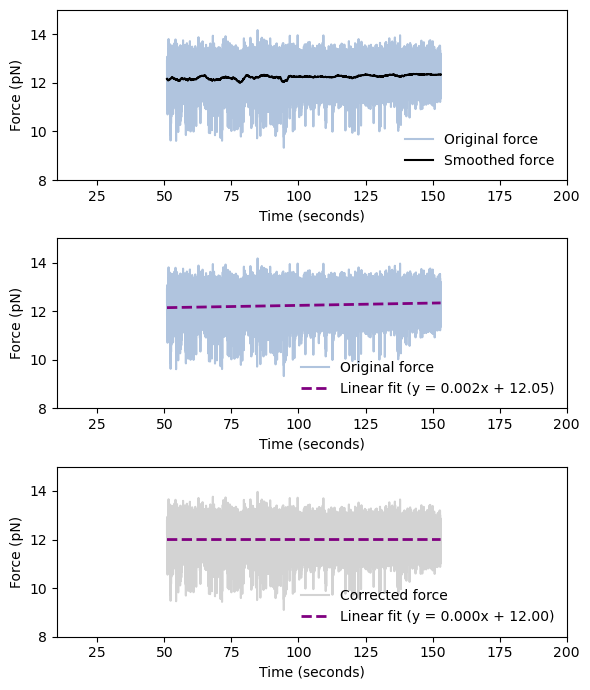

In [58]:
n1c = linear_correction(n1)
n2c = linear_correction(n2)
n3c = linear_correction(n3)
n4c = linear_correction(n4)
n5c = linear_correction(n5)
n6c = linear_correction(n6)
n7c = linear_correction(n7)
n8c = linear_correction(n8)
n9c = linear_correction(n9)

In [ ]:
n1_pb = pd.read_csv('/formatted/PDGFRA/Cterm_Nuc/Naked/110924N322.csv')
n2_pb = pd.read_csv('/formatted/PDGFRA/Cterm_Nuc/Naked/110924N328.csv')
n4_pb = pd.read_csv('/formatted/PDGFRA/Cterm_Nuc/Naked/110924N330.csv')

##### Methylated N-term CTCF WT

In [ ]:
m1 = pd.read_csv('/formatted/Methylation/030924N52.csv')
m2 = pd.read_csv('/formatted/Methylation/030924N121.csv')
m3 = pd.read_csv('/formatted/Methylation/030924N123.csv')
m4 = pd.read_csv('/formatted/Methylation/030924N125.csv')
m5 = pd.read_csv('/formatted/Methylation/241212N32.csv')
m6 = pd.read_csv('/formatted/Methylation/241212N75.csv')
m7 = pd.read_csv('/formatted/Methylation/241212N28.csv')

##### N-term CTCF WT w/ PDS5a

In [ ]:
p5_1 = pd.read_csv('/formatted/PDGFRA/N_term_PDS5A/250416N116.csv')
p5_2 = pd.read_csv('/formatted/PDGFRA/N_term_PDS5A/250416N118.csv')
p5_3 = pd.read_csv('/formatted/PDGFRA/N_term_PDS5A/250416N128.csv')
p5_4 = pd.read_csv('/formatted/PDGFRA/N_term_PDS5A/250416N143.csv')
p5_5 = pd.read_csv('/formatted/PDGFRA/N_term_PDS5A/250416N147.csv')
p5_6 = pd.read_csv('/formatted/PDGFRA/N_term_PDS5A/250416N149.csv')
p5_7 = pd.read_csv('/formatted/PDGFRA/N_term_PDS5A/250416N151.csv')
p5_8 = pd.read_csv('/formatted/PDGFRA/N_term_PDS5A/250416N153.csv')

In [ ]:
p5_1_bp = pd.read_csv('/formatted/bp/PDGFRA_N_pds5a_bp_converted_2khz/fixed_intercept/160425N116.csv')
p5_2_bp = pd.read_csv('/formatted/bp/PDGFRA_N_pds5a_bp_converted_2khz/fixed_intercept/160425N118.csv')
p5_4_bp = pd.read_csv('/formatted/bp/PDGFRA_N_pds5a_bp_converted_2khz/fixed_intercept/160425N143.csv')
p5_5_bp = pd.read_csv('/formatted/bp/PDGFRA_N_pds5a_bp_converted_2khz/fixed_intercept/160425N147.csv')
p5_6_bp = pd.read_csv('/formatted/bp/PDGFRA_N_pds5a_bp_converted_2khz/fixed_intercept/160425N149.csv')
p5_7_bp = pd.read_csv('/formatted/bp/PDGFRA_N_pds5a_bp_converted_2khz/fixed_intercept/160425N151.csv')
p5_8_bp = pd.read_csv('/formatted/bp/PDGFRA_N_pds5a_bp_converted_2khz/fixed_intercept/160425N153.csv')

##### N-term CTCF WT w/ Cohesin

In [ ]:
oc_1 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin/250604N53.csv')
oc_2 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin/250604N64.csv')
oc_3 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin/250604N92.csv')
oc_4 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin/250604N94.csv')
oc_5 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin/250604N101.csv')
oc_6 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin/250604N125.csv')
oc_7 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin/250604N167.csv')
oc_8 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin/250701N20.csv')
oc_9 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin/250701N22.csv')
oc_10 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin/250701N30_1.csv')
oc_11 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin/250701N30_2.csv')
oc_12 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin/250701N32.csv')
oc_13 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin/250701N40.csv')
oc_14 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin/250701N41.csv')
oc_15 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin/250701N42.csv')
oc_16 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin/250701N43.csv')
oc_17 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin/250701N45.csv')
oc_18 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin/250701N46.csv')
oc_19 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin/250701N50.csv')
oc_20 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin/250701N52.csv')

In [ ]:
oc1_bp = pd.read_csv('/formatted/bp/PDGFRA_N_cohesin_bp_converted_2khz/fixed_intercept/040625N53.csv')
oc3_bp = pd.read_csv('/formatted/bp/PDGFRA_N_cohesin_bp_converted_2khz/fixed_intercept/040625N92.csv')
oc4_bp = pd.read_csv('/formatted/bp/PDGFRA_N_cohesin_bp_converted_2khz/fixed_intercept/040625N94.csv')
oc5_bp = pd.read_csv('/formatted/bp/PDGFRA_N_cohesin_bp_converted_2khz/fixed_intercept/040625N101.csv')
oc6_bp = pd.read_csv('/formatted/bp/PDGFRA_N_cohesin_bp_converted_2khz/fixed_intercept/040625N125.csv')

##### N-term CTCF WT w/ Cohesin & PDS5A

In [ ]:
pc_1 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin_PDS5A/250604N186.csv')
pc_2 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin_PDS5A/250604N204.csv')
pc_3 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin_PDS5A/250604N215.csv')
pc_4 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin_PDS5A/250604N235.csv')
pc_5 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin_PDS5A/250604N236.csv')
pc_6 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin_PDS5A/250604N240.csv')
pc_7 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin_PDS5A/250702N8.csv')
pc_8 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin_PDS5A/250702N15.csv')
pc_9 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin_PDS5A/250702N16_dyn.csv')
pc_10 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin_PDS5A/250702N17.csv')
pc_11 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin_PDS5A/250702N18.csv')
pc_12 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin_PDS5A/250702N26.csv')
pc_13 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin_PDS5A/250702N32.csv')
pc_14 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin_PDS5A/250702N35.csv')
pc_15 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin_PDS5A/250702N36.csv')
pc_16 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin_PDS5A/250702N38.csv')
pc_17 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin_PDS5A/250702N47.csv')
pc_18 = pd.read_csv('/formatted/PDGFRA/Nterm_Cohesin_PDS5A/250702N54.csv')

In [ ]:
pc_4_bp = pd.read_csv('/formatted/bp/PDGFRA_N_cohesin_pds5a_converted_2khz/fixed_intercept/040625N235.csv')
pc_6_bp = pd.read_csv('/formatted/bp/PDGFRA_N_cohesin_pds5a_converted_2khz/fixed_intercept/040625N240.csv')
pc_11_bp = pd.read_csv('/formatted/bp/PDGFRA_N_cohesin_pds5a_converted_2khz/fixed_intercept/020725N18.csv')
pc_13_bp = pd.read_csv('/formatted/bp/PDGFRA_N_cohesin_pds5a_converted_2khz/fixed_intercept/020725N32.csv')
pc_14_bp = pd.read_csv('/formatted/bp/PDGFRA_N_cohesin_pds5a_converted_2khz/fixed_intercept/020725N35.csv')

#### Consensus

In [ ]:
c1 = pd.read_csv('/formatted/Consensus/240701N22.csv')
c2 = pd.read_csv('/formatted/Consensus/240701N38.csv')
c3 = pd.read_csv('/formatted/Consensus/240701N39.csv')
c5 = pd.read_csv('/formatted/Consensus/241212N28.csv')
c7 = pd.read_csv('/formatted/Consensus/241217N26.csv')
c8 = pd.read_csv('/formatted/Consensus/241217N29.csv')
c9 = pd.read_csv('/formatted/Consensus/241217N33.csv')
c10 = pd.read_csv('/formatted/Consensus/241217N35.csv')
c11 = pd.read_csv('/formatted/Consensus/241217N39.csv')

### Analysis

#### PDGFRA N-term Naked DNA

In [ ]:
traces = [dna1, dna2, dna3, dna4, dna5]
res = fit_final_hmm(
    traces, K=2,
    n_iter=1000,
    save_path="final_models/pdgfra_nterm_naked_dna_2_model.pkl"
)
print(res["K"], res["log_likelihood"], res["BIC"])

         1 -2356723.24315925             +nan
         2 -173557.76086868 +2183165.48229057
         3 -167258.20970227   +6299.55116641
         4 -165553.52282999   +1704.68687228
         5 -165068.48871481    +485.03411518
         6 -164931.47053061    +137.01818420
         7 -164892.75133861     +38.71919200
         8 -164881.68724228     +11.06409633
         9 -164878.45788581      +3.22935648
        10 -164877.48672165      +0.97116416
        11 -164877.18388066      +0.30284099
        12 -164877.08565012      +0.09823053
        13 -164877.05252346      +0.03312667
        14 -164877.04095119      +0.01157227
        15 -164877.03678669      +0.00416450
        16 -164877.03525238      +0.00153431


2 -164877.0344583546 329839.98503576725


        17 -164877.03467694      +0.00057544


In [87]:
traces = [dna]
res = fit_final_hmm(
    traces, K=2,
    n_iter=1000,
    feature_col='force (pN)',
    save_path="final_models/pdgfra_nterm_naked_uncorrected_2_model.pkl"
)
print(res["K"], res["log_likelihood"], res["BIC"])

2 -11165.801903229058 22398.431494718297


         1 -105491.03504684             +nan
         2  -12571.34564706  +92919.68939978
         3  -11909.18882400    +662.15682306
         4  -11520.20340972    +388.98541428
         5  -11306.67266666    +213.53074306
         6  -11213.59234328     +93.08032338
         7  -11180.39280403     +33.19953925
         8  -11170.01396822     +10.37883581
         9  -11166.98766523      +3.02630299
        10  -11166.13225367      +0.85541156
        11  -11165.89354837      +0.23870529
        12  -11165.82727264      +0.06627574
        13  -11165.80890384      +0.01836880
        14  -11165.80381440      +0.00508944
        15  -11165.80240362      +0.00141078
        16  -11165.80201211      +0.00039151


In [86]:
traces = [ctcf]
res = fit_final_hmm(
    traces, K=4,
    n_iter=1000,
    feature_col='force (pN)',
    save_path="final_models/pdgfra_nterm_ctcf_uncorrected_2_model.pkl"
)
print(res["K"], res["log_likelihood"], res["BIC"])

         1 -498042.62859417             +nan
         2 -261763.60797409 +236279.02062008
         3 -250568.29600613  +11195.31196796
         4 -240147.16327281  +10421.13273332
         5 -233983.79631617   +6163.36695664
         6 -232227.26268812   +1756.53362805
         7 -231908.37907885    +318.88360926
         8 -231833.62530473     +74.75377412
         9 -231794.03320383     +39.59210091
        10 -231763.06953833     +30.96366550
        11 -231735.98211537     +27.08742296
        12 -231711.10391799     +24.87819738
        13 -231687.69893778     +23.40498022
        14 -231665.60337988     +22.09555790
        15 -231644.93015041     +20.67322947
        16 -231625.74344440     +19.18670601
        17 -231607.97076380     +17.77268060
        18 -231591.47603281     +16.49473099
        19 -231576.13027031     +15.34576250
        20 -231561.83879082     +14.29147949
        21 -231548.53784933     +13.30094149
        22 -231536.17914271     +12.35870663
        23

4 -231180.1392284952 462656.0216071165


      1000 -231180.14242415      +0.00320998


#### PDGFRA N-term CTCF WT

In [44]:
traces = [p1, p2, p3, p4, p5, p6, p7, p8, p9, p10]
res = fit_final_hmm(
    traces, K=4,
    n_iter=1000,
    save_path="final_models/pdgfra_nterm_ctcfwt_4_model.pkl"
)
print(res["K"], res["log_likelihood"], res["BIC"])

         1 -3135065.34632690             +nan
         2 -1640598.57206299 +1494466.77426391
         3 -1592418.39208989  +48180.17997310
         4 -1561862.17911073  +30556.21297916
         5 -1548555.69934884  +13306.47976189
         6 -1545030.79481786   +3524.90453097
         7 -1544009.66883842   +1021.12597945
         8 -1543566.54079486    +443.12804356
         9 -1543286.25738852    +280.28340634
        10 -1543062.55491476    +223.70247376
        11 -1542863.06933951    +199.48557525
        12 -1542677.31591991    +185.75341960
        13 -1542501.89306018    +175.42285974
        14 -1542335.62702786    +166.26603232
        15 -1542177.96926690    +157.65776095
        16 -1542028.50218341    +149.46708349
        17 -1541886.80594825    +141.69623517
        18 -1541752.44154945    +134.36439880
        19 -1541624.96759125    +127.47395819
        20 -1541503.95805558    +121.00953567
        21 -1541389.01168537    +114.94637022
        22 -1541279.75353131    +

4 -1536642.4979074798 3073623.9447041852


In [ ]:
aic_bic_hmm_states_convergence_minmax(
    traces,
    min_no_states=1,
    max_no_states=6,
    cross_val=False,
    n_splits=1,
    convergence_threshold=0.01,
    max_iter=300,
    n_jobs=-1,
    save_dir="'new_models/pdgfra_nterm_ctcfwt_models/"
)

#### PDGFRA N-term CTCF DeltaN

In [67]:
traces = [pdn1, pdn2, pdn3, pdn4, pdn5]
res = fit_final_hmm(
    traces, K=4,
    n_iter=1000,
    save_path="final_models/pdgfra_nterm_ctcfdn_4_model.pkl"
)
print(res["K"], res["log_likelihood"], res["BIC"])


         1 -1329105.82663331             +nan
         2 -734282.31247069 +594823.51416262
         3 -717376.00446795  +16906.30800274
         4 -708369.57074881   +9006.43371913
         5 -704681.19689576   +3688.37385305
         6 -703534.60100201   +1146.59589375
         7 -703121.18766156    +413.41334045
         8 -702922.99399443    +198.19366713
         9 -702801.09289828    +121.90109614
        10 -702710.90976440     +90.18313388
        11 -702635.59039081     +75.31937359
        12 -702568.11215650     +67.47823431
        13 -702505.40846998     +62.70368653
        14 -702446.32897927     +59.07949071
        15 -702390.35335588     +55.97562339
        16 -702337.08968962     +53.26366626
        17 -702286.29361649     +50.79607313
        18 -702237.82760239     +48.46601410
        19 -702191.60816416     +46.21943823
        20 -702147.57309391     +44.03507025
        21 -702105.66324725     +41.90984666
        22 -702065.81331150     +39.84993575
        2

4 -700390.3636586757 1401099.0475020313


      1000 -700390.37341677      +0.00972682


#### PDGFRA Methylated N-term CTCF

In [68]:
traces = [m1, m2, m3, m4, m5, m6, m7]

res = fit_final_hmm(
    traces, K=4,
    n_iter=1000,
    save_path="final_models/pdgfra_methylated_nterm_ctcfwt_4_model.pkl"
)
print(res["K"], res["log_likelihood"], res["BIC"])


         1 -1295332.54300292             +nan
         2 -701668.04702974 +593664.49597318
         3 -694061.87516841   +7606.17186132
         4 -691454.10196729   +2607.77320112
         5 -689909.52162237   +1544.58034492
         6 -688659.85148268   +1249.67013970
         7 -687481.50041764   +1178.35106504
         8 -686370.71958856   +1110.78082908
         9 -685382.87386825    +987.84572030
        10 -684561.86897422    +821.00489403
        11 -683910.78504093    +651.08393329
        12 -683406.23148458    +504.55355635
        13 -683015.24274137    +390.98874322
        14 -682708.20040313    +307.04233823
        15 -682462.67958450    +245.52081863
        16 -682262.63403823    +200.04554628
        17 -682096.56690782    +166.06713041
        18 -681956.22621037    +140.34069745
        19 -681835.68088809    +120.54532228
        20 -681730.63006275    +105.05082534
        21 -681637.91030987     +92.71975288
        22 -681555.15703044     +82.75327942
        2

4 -678824.0239527756 1357966.9946268788


       819 -678824.02493527      +0.00099430


#### PDGFRA N-term CTCF WT w/ PDS5A

In [39]:
traces = [p5_1, p5_2, p5_3, p5_4, p5_5, p5_6, p5_7, p5_8]
res = fit_final_hmm(
    traces, K=4,
    n_iter=1000,
    save_path="final_models/pdgfra_nterm_ctcfwt_pds5a_4_model.pkl"
)
print(res["K"], res["log_likelihood"], res["BIC"])


         1 -3065308.44900289             +nan
         2 -1703718.03375600 +1361590.41524690
         3 -1673980.79187936  +29737.24187664
         4 -1663126.61304650  +10854.17883286
         5 -1659158.09056605   +3968.52248045
         6 -1657562.28381577   +1595.80675027
         7 -1656814.49736566    +747.78645011
         8 -1656415.86649039    +398.63087527
         9 -1656180.65612289    +235.21036751
        10 -1656028.83442098    +151.82170191
        11 -1655922.33167145    +106.50274953
        12 -1655841.74282565     +80.58884580
        13 -1655776.66737543     +65.07545022
        14 -1655721.31715236     +55.35022307
        15 -1655672.37454541     +48.94260694
        16 -1655627.89023176     +44.48431365
        17 -1655586.69199268     +41.19823908
        18 -1655548.05734903     +38.63464364
        19 -1655511.52821092     +36.52913811
        20 -1655476.80383784     +34.72437308
        21 -1655443.67834082     +33.12549702
        22 -1655412.00360482     

4 -1653558.8890802353 3307454.527225641



▶ Starting fit for 4 states…


         1 -2181817.20193866             +nan
         2 -1208109.83968256 +973707.36225609
         3 -1205988.35391967   +2121.48576289
         4 -1204858.72066072   +1129.63325895
         5 -1204029.05576680    +829.66489392
         6 -1203354.11709868    +674.93866812
         7 -1202777.79370761    +576.32339108
         8 -1202271.51613717    +506.27757043
         9 -1201818.21407003    +453.30206714
        10 -1201406.50099826    +411.71307178
        11 -1201028.18599645    +378.31500181
        12 -1200677.07556415    +351.11043229
        13 -1200348.34119946    +328.73436469
        14 -1200038.14274571    +310.19845375
        15 -1199743.39464789    +294.74809782
        16 -1199461.60544516    +281.78920273
        17 -1199190.75838700    +270.84705816
        18 -1198929.22805291    +261.53033410
        19 -1198675.71231812    +253.51573479
        20 -1198429.17373581    +246.53858231
        21 -1198188.79426546    +240.37947035
        22 -1197953.93777059    +2

   Log-likelihood history saved: new_models/pdgfra_nterm_ctcfwt_pds5a_small_models/loglikelihood_4_states.csv
✔ Model saved to new_models/pdgfra_nterm_ctcfwt_pds5a_small_models/model_4_states.pkl
✔ Done 4 states: AIC=2375518.9, BIC=2375802.2, LL=-1187736.4


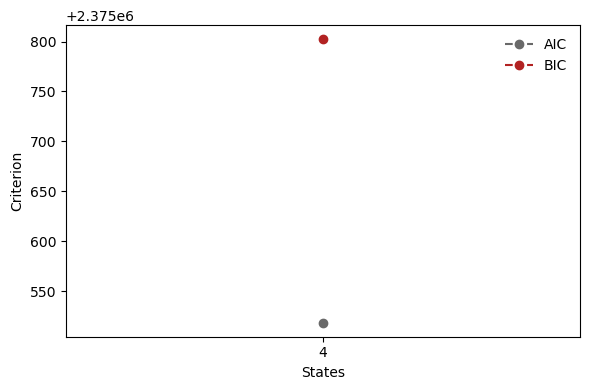

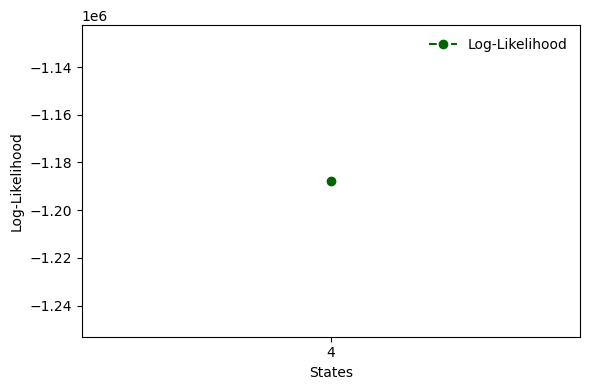

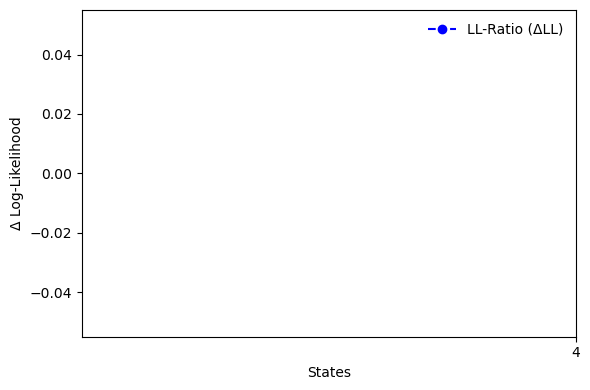

Summary saved to new_models/pdgfra_nterm_ctcfwt_pds5a_small_models/aic_bic_ll_summary.csv
AIC values: [2375518.891877454]
BIC values: [2375802.1803870806]
Log-likelihood values: [-1187736.445938727]
LL ratio values: [nan]


In [ ]:
# RUN
traces = [p5_1, p5_4, p5_5, p5_6, p5_7, p5_8]

# Run the function
results = aic_bic_hmm_states_convergence_minmax(
    traces=traces,
    min_no_states=1,           # minimum number of states to test
    max_no_states=6,           # maximum number of states to test
    cross_val=False,           # set True if you want k-fold CV
    n_splits=1,                # only used if cross_val=True
    convergence_threshold=0.01,
    max_iter=300,
    save_dir="new_models/pdgfra_nterm_ctcfwt_pds5a_models"  # where models and CSV files are saved
)

# Access returned values
print("AIC values:", results["aic"])
print("BIC values:", results["bic"])
print("Log-likelihood values:", results["ll"])
print("LL ratio values:", results["ll_ratio"])



▶ Starting fit for 4 states…


         1 -4995605.26700424             +nan
         2 -1186879.07498109 +3808726.19202314
         3 -1162634.07896494  +24244.99601615
         4 -1154805.56263105   +7828.51633390
         5 -1150923.37707578   +3882.18555527
         6 -1148451.83663998   +2471.54043580
         7 -1146623.60199287   +1828.23464711
         8 -1145151.37383066   +1472.22816222
         9 -1143904.68874685   +1246.68508380
        10 -1142809.81811128   +1094.87063557
        11 -1141820.54111854    +989.27699275
        12 -1140909.16071489    +911.38040365
        13 -1140059.31316862    +849.84754626
        14 -1139261.12053691    +798.19263171
        15 -1138508.27753576    +752.84300115
        16 -1137796.53039121    +711.74714455
        17 -1137123.02492465    +673.50546657
        18 -1136485.98931813    +637.03560652
        19 -1135884.42657983    +601.56273829
        20 -1135317.78847223    +566.63810760
        21 -1134785.68865016    +532.09982208
        22 -1134287.65739675    +

   Log-likelihood history saved: new_models/pdgfra_nterm_ctcfwt_pds5a_firm_models/loglikelihood_4_states.csv
✔ Model saved to new_models/pdgfra_nterm_ctcfwt_pds5a_firm_models/model_4_states.pkl
✔ Done 4 states: AIC=2255126.9, BIC=2255410.1, LL=-1127540.4

🏁 Best K by BIC: 4


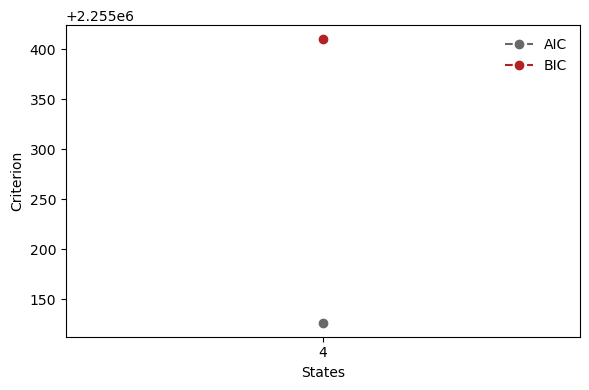

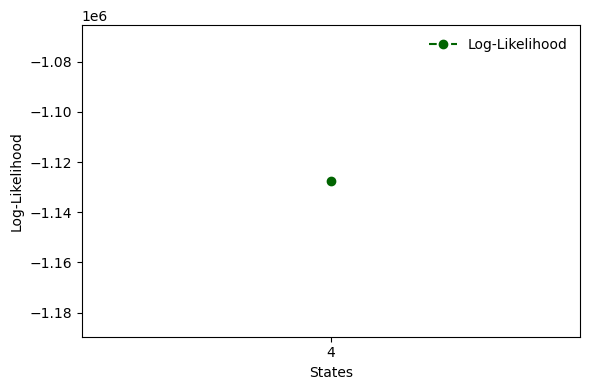

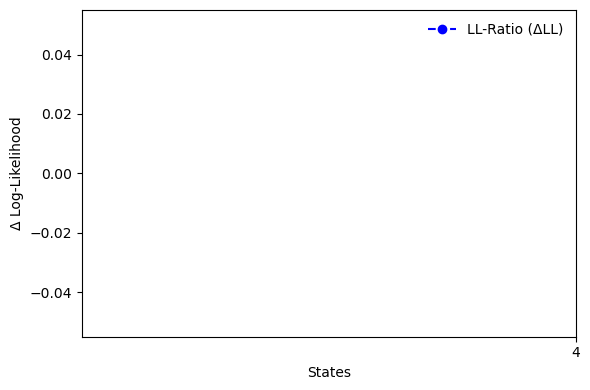

Summary saved to new_models/pdgfra_nterm_ctcfwt_pds5a_firm_models/aic_bic_ll_summary.csv

🔁 Re-fitting final model at K=4 with tol=0.0001, n_iter=2000 …


         1 -2112099.33347829             +nan
         2 -1153686.22975132 +958413.10372697
         3 -1139104.50986794  +14581.71988338
         4 -1134577.65291969   +4526.85694825
         5 -1132725.17241023   +1852.48050946
         6 -1131918.93460982    +806.23780041
         7 -1131532.72927065    +386.20533917
         8 -1131309.11348897    +223.61578168
         9 -1131157.56006104    +151.55342793
        10 -1131042.14377167    +115.41628937
        11 -1130946.75360452     +95.39016715
        12 -1130863.52313212     +83.23047240
        13 -1130788.35871976     +75.16441237
        14 -1130719.00774343     +69.35097632
        15 -1130654.16206239     +64.84568105
        16 -1130593.01941367     +61.14264872
        17 -1130535.05912993     +57.96028373
        18 -1130479.92266370     +55.13646623
        19 -1130427.34754624     +52.57511746
        20 -1130377.12979357     +50.21775267
        21 -1130329.10213371     +48.02765986
        22 -1130283.12132834     +

✔ Final model LL=-1127370.8 (EM steps: 1846)
💾 Final model saved to new_models/pdgfra_nterm_ctcfwt_pds5a_firm_models/final_model_4_states.pkl


{'aic': [2255126.878473861],
 'bic': [2255410.111192072],
 'll': [-1127540.4392369306],
 'll_ratio': [nan],
 'fold_lls': {4: None},
 'fitted_states': [4],
 'best_K': 4,
 'final_model_path': 'new_models/pdgfra_nterm_ctcfwt_pds5a_firm_models/final_model_4_states.pkl',
 'perK_model_paths': ['new_models/pdgfra_nterm_ctcfwt_pds5a_firm_models/model_4_states.pkl'],
 'summary_csv': 'new_models/pdgfra_nterm_ctcfwt_pds5a_firm_models/aic_bic_ll_summary.csv'}

In [19]:
aic_bic_hmm_states_convergence_minmax_firm(traces=traces,
    min_no_states=4,           # minimum number of states to test
    max_no_states=4,           # maximum number of states to test
    cross_val=False,           # set True if you want k-fold CV
    n_splits=1,                # only used if cross_val=True
    convergence_threshold=0.01,
    max_iter=300,
    save_dir="new_models/pdgfra_nterm_ctcfwt_pds5a_firm_models"  # where models and CSV files are saved
)

#### PDGFRA N-term CTCF WT w/ Cohesin

In [40]:
traces = [oc_1, oc_2, oc_3, oc_4, oc_5, oc_6, oc_7, oc_8, oc_9, oc_10, oc_11, oc_12, oc_13, oc_14, oc_15, oc_17, oc_18, oc_19, oc_20]
res = fit_final_hmm(
    traces, K=4,
    n_iter=1000,
    save_path="final_models/pdgfra_nterm_ctcfwt_cohesin_4_model.pkl"
)
print(res["K"], res["log_likelihood"], res["BIC"])


         1 -9182130.92230484             +nan
         2 -5122322.18432143 +4059808.73798341
         3 -5049947.08748804  +72375.09683339
         4 -5017523.27108138  +32423.81640666
         5 -5002414.32940304  +15108.94167833
         6 -4996454.10233707   +5960.22706598
         7 -4993809.57765858   +2644.52467849
         8 -4992359.54201766   +1450.03564091
         9 -4991402.71113741    +956.83088025
        10 -4990678.06987009    +724.64126732
        11 -4990076.53815752    +601.53171258
        12 -4989547.61563612    +528.92252139
        13 -4989066.18631166    +481.42932446
        14 -4988618.92440038    +447.26191128
        15 -4988198.26980084    +420.65459954
        16 -4987799.62492701    +398.64487383
        17 -4987419.98298334    +379.64194367
        18 -4987057.23494783    +362.74803551
        19 -4986709.81237902    +347.42256880
        20 -4986376.49951311    +333.31286591
        21 -4986056.32744990    +320.17206321
        22 -4985748.50499480    +

4 -4971909.163421331 9944180.513750713



▶ Starting fit for 4 states…


         1 -1905582.13549424             +nan
         2 -1808655.67023288  +96926.46526136
         3 -1800097.16050864   +8558.50972424
         4 -1793798.51869812   +6298.64181052
         5 -1788969.57722717   +4828.94147095
         6 -1784589.31577686   +4380.26145031
         7 -1780316.17212718   +4273.14364968
         8 -1776144.58039820   +4171.59172898
         9 -1772167.92142423   +3976.65897398
        10 -1768505.51904457   +3662.40237966
        11 -1765267.31613739   +3238.20290718
        12 -1762527.89028159   +2739.42585580
        13 -1760311.18255039   +2216.70773120
        14 -1758590.28766431   +1720.89488608
        15 -1757300.83314851   +1289.45451580
        16 -1756360.33478241    +940.49836610
        17 -1755685.62262808    +674.71215432
        18 -1755204.00581327    +481.61681481
        19 -1754857.84557569    +346.16023758
        20 -1754604.51174613    +253.33382955
        21 -1754413.98042590    +190.53132023
        22 -1754265.82182519    +1

   Log-likelihood history saved: new_models/pdgfra_nterm_ctcfwt_cohesin_small_models/loglikelihood_4_states.csv
✔ Model saved to new_models/pdgfra_nterm_ctcfwt_cohesin_small_models/model_4_states.pkl
✔ Done 4 states: AIC=3492404.6, BIC=3492696.2, LL=-1746179.3


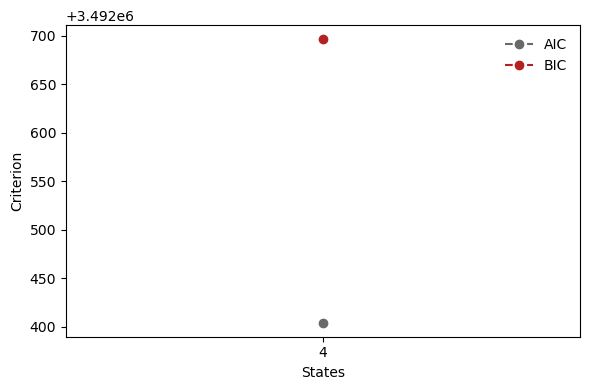

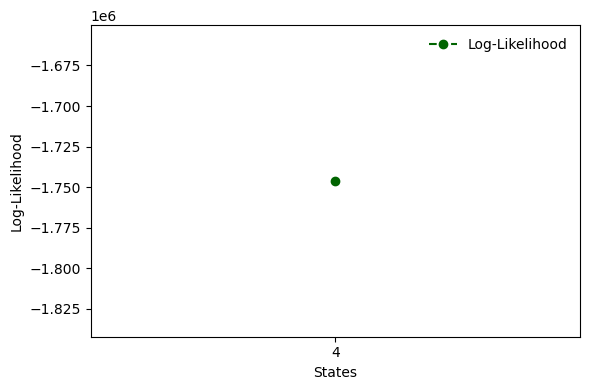

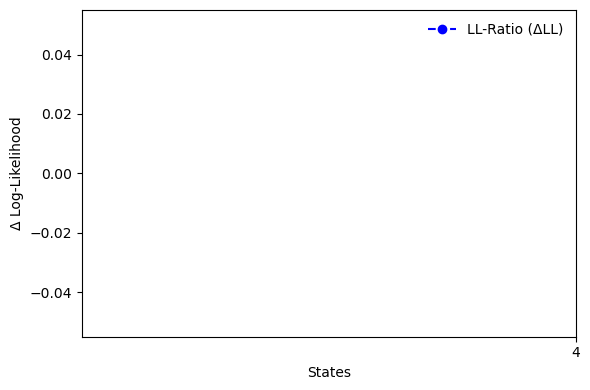

Summary saved to new_models/pdgfra_nterm_ctcfwt_cohesin_small_models/aic_bic_ll_summary.csv
AIC values: [3492404.555310428]
BIC values: [3492696.150757206]
Log-likelihood values: [-1746179.277655214]
LL ratio values: [nan]


In [15]:
# RUN
traces = [oc_1, oc_3, oc_4, oc_5, oc_6]

# Run the function
results = aic_bic_hmm_states_convergence_minmax(
    traces=traces,
    min_no_states=4,           # minimum number of states to test
    max_no_states=4,           # maximum number of states to test
    cross_val=False,           # set True if you want k-fold CV
    n_splits=1,                # only used if cross_val=True
    convergence_threshold=0.01,
    max_iter=300,
    save_dir="new_models/pdgfra_nterm_ctcfwt_cohesin_small_models"  # where models and CSV files are saved
)

# Access returned values
print("AIC values:", results["aic"])
print("BIC values:", results["bic"])
print("Log-likelihood values:", results["ll"])
print("LL ratio values:", results["ll_ratio"])


#### PDGFRA N-term CTCF WT w/ Cohesin & PDS5A

In [69]:
traces = [pc_7, pc_8, pc_9, pc_10, pc_11, pc_12, pc_13, pc_14, pc_16]
res = fit_final_hmm(
    traces, K=4,
    n_iter=1000,
    save_path="final_models/pdgfra_nterm_ctcfwt_cohesin_pds5a_4_model.pkl"
)
print(res["K"], res["log_likelihood"], res["BIC"])


         1 -3699335.05771719             +nan
         2 -2018849.10552732 +1680485.95218987
         3 -1983263.73296803  +35585.37255929
         4 -1962733.44004144  +20530.29292660
         5 -1950737.57962343  +11995.86041801
         6 -1945597.58003360   +5139.99958983
         7 -1943856.89112276   +1740.68891085
         8 -1943173.23532067    +683.65580208
         9 -1942788.40749167    +384.82782900
        10 -1942509.26615395    +279.14133772
        11 -1942274.51921528    +234.74693867
        12 -1942060.54109796    +213.97811732
        13 -1941857.37704906    +203.16404890
        14 -1941660.94380896    +196.43324010
        15 -1941469.85390457    +191.08990439
        16 -1941283.93363041    +185.92027415
        17 -1941103.48584402    +180.44778639
        18 -1940928.92177073    +174.56407329
        19 -1940760.59142802    +168.33034272
        20 -1940598.72370132    +161.86772670
        21 -1940443.42134947    +155.30235185
        22 -1940294.67868146    +

4 -1934312.3843092127 3868966.707122165


#### Consensus N-term CTCF WT

In [70]:
traces = [c1, c2, c3, c5, c7, c8, c9, c10, c11]
res = fit_final_hmm(
    traces, K=4,
    n_iter=1000,
    save_path="final_models/consensus_nterm_ctcfwt_4_model.pkl"
)
print(res["K"], res["log_likelihood"], res["BIC"])


         1 -4463120.31003266             +nan
         2 -2367031.61114611 +2096088.69888655
         3 -2339602.42380820  +27429.18733791
         4 -2332275.86122802   +7326.56258018
         5 -2329423.93975819   +2851.92146983
         6 -2327931.12982661   +1492.80993157
         7 -2326934.24724458    +996.88258203
         8 -2326148.12249868    +786.12474590
         9 -2325468.68724889    +679.43524979
        10 -2324855.66180231    +613.02544658
        11 -2324292.39029319    +563.27150912
        12 -2323771.00727078    +521.38302241
        13 -2323286.90163359    +484.10563719
        14 -2322836.71207091    +450.18956268
        15 -2322417.65375734    +419.05831358
        16 -2322027.28162201    +390.37213533
        17 -2321663.39989126    +363.88173074
        18 -2321324.00035965    +339.39953161
        19 -2321007.22808734    +316.77227232
        20 -2320711.35852858    +295.86955875
        21 -2320434.79715567    +276.56137291
        22 -2320176.07027689    +

4 -2313806.7710050517 4627960.5290736575


#### PDGFRA C-term CTCF WT

In [71]:
traces = [pc1, pc2, pc3, pc4, pc5]
res = fit_final_hmm(
    traces, K=4,
    n_iter=1000,
    save_path="final_models/pdgfra_cterm_ctcfwt_4_model.pkl"
)
print(res["K"], res["log_likelihood"], res["BIC"])


         1 -1903017.25901111             +nan
         2 -1130884.29612740 +772132.96288371
         3 -1107864.75168598  +23019.54444142
         4 -1091268.65942037  +16596.09226561
         5 -1074394.61175149  +16874.04766888
         6 -1055752.56668551  +18642.04506599
         7 -1037457.92454470  +18294.64214080
         8 -1021481.87798654  +15976.04655817
         9 -1008354.62032828  +13127.25765826
        10 -998246.73973267  +10107.88059561
        11 -991083.09367980   +7163.64605287
        12 -986353.27773588   +4729.81594392
        13 -983363.69126487   +2989.58647101
        14 -981494.33632308   +1869.35494179
        15 -980293.52418984   +1200.81213324
        16 -979469.34520088    +824.17898896
        17 -978844.83460311    +624.51059777
        18 -978319.25402892    +525.58057419
        19 -977839.80965770    +479.44437121
        20 -977379.50742932    +460.30222838
        21 -976920.83454672    +458.67288260
        22 -976447.98916224    +472.84538448
 

4 -969403.8542189697 1939130.2265066684


       122 -969403.85506984      +0.00097565


#### PDGFRA Nuclesome C-term CTCF WT

In [ ]:
traces = [n1, n2, n3, n4, n5, n6, n7, n8, n9]
res = fit_final_hmm(
    traces, K=4,
    n_iter=1000,
    save_path="final_models/pdgfra_nuc_cterm_ctcfwt_4_model.pkl"
)
print(res["K"], res["log_likelihood"], res["BIC"])

         1 -1312526.84977752             +nan
         2 -637546.11478740 +674980.73499012
         3 -611430.89310562  +26115.22168178
         4 -578971.92227112  +32458.97083449
         5 -545788.70383758  +33183.21843354
         6 -524603.06154535  +21185.64229223
         7 -515946.54241477   +8656.51913058
         8 -512887.40560242   +3059.13681235
         9 -511267.29820639   +1620.10739603
        10 -509949.00006530   +1318.29814109
        11 -508799.40208672   +1149.59797857
        12 -507820.21259620    +979.18949052
        13 -506997.09312206    +823.11947414
        14 -506308.91996859    +688.17315347
        15 -505736.31571990    +572.60424869
        16 -505257.67751212    +478.63820779
        17 -504853.81166191    +403.86585020
        18 -504509.69751803    +344.11414389
        19 -504213.74546764    +295.95205039
        20 -503956.69387499    +257.05159265
        21 -503730.99030663    +225.70356837
        22 -503530.54434771    +200.44595892
        2

4 -500445.57223540766 1001209.8651299193


       452 -500445.57318649      +0.00099719


In [13]:
traces = [n1_pb, n2_pb, n4_pb]
res = fit_final_hmm(
    traces, K=2,
    n_iter=1000,
    save_path="final_models/pdgfra_nucleosome_prebinding_cterm_ctcfwt_2_model.pkl"
)
print(res["K"], res["log_likelihood"], res["BIC"])

2 -26302.861311048277 52679.08332851443


         1 -301202.37913376             +nan
         2  -29396.37694450 +271806.00218926
         3  -27591.63828005   +1804.73866445
         4  -26818.63462545    +773.00365460
         5  -26487.57899337    +331.05563208
         6  -26363.65482548    +123.92416788
         7  -26321.84556655     +41.80925894
         8  -26308.63233794     +13.21322861
         9  -26304.61788453      +4.01445341
        10  -26303.41283804      +1.20504648
        11  -26303.04491888      +0.36791917
        12  -26302.92735162      +0.11756726
        13  -26302.88705801      +0.04029361
        14  -26302.87204084      +0.01501717
        15  -26302.86596500      +0.00607583
        16  -26302.86333475      +0.00263025
        17  -26302.86213953      +0.00119522
        18  -26302.86157902      +0.00056051


### Base-pairs

#### PDGFRA N-term CTCF WT

In [74]:
# Example traces list
traces = [p1_bp, p2_bp, p3_bp, p4_bp]
res = fit_final_hmm(
    traces, K=4,
    n_iter=1000,
    feature_col='bp_corrected',
    save_path="final_models/bp_pdgfra_nterm_ctcfwt_4_model.pkl"
)
print(res["K"], res["log_likelihood"], res["BIC"])


         1 -5472431.84838110             +nan
         2 -4624115.68576251 +848316.16261858
         3 -4554457.94000949  +69657.74575302
         4 -4524556.93912108  +29901.00088841
         5 -4520139.50878208   +4417.43033900
         6 -4519332.33044190    +807.17834019
         7 -4518775.16049280    +557.16994910
         8 -4518200.12479538    +575.03569742
         9 -4517603.24617669    +596.87861868
        10 -4517007.78263438    +595.46354232
        11 -4516432.15139511    +575.63123927
        12 -4515890.84290092    +541.30849419
        13 -4515391.45975857    +499.38314235
        14 -4514934.18175176    +457.27800681
        15 -4514515.28322245    +418.89852931
        16 -4514130.08756623    +385.19565623
        17 -4513774.19855201    +355.88901422
        18 -4513443.82190840    +330.37664361
        19 -4513135.76220481    +308.05970359
        20 -4512847.35919486    +288.40300994
        21 -4512576.39429062    +270.96490424
        22 -4512321.02112517    +2

4 -4505888.159682588 9012099.208317688


       493 -4505888.16062686      +0.00096244



▶ Starting fit for 3 states…


         1 -5900516.42991565             +nan
         2 -4752423.55036655 +1148092.87954910
         3 -4707697.91879457  +44725.63157198
         4 -4697587.40847242  +10110.51032215
         5 -4692966.21443402   +4621.19403840
         6 -4690301.87586339   +2664.33857063
         7 -4688974.94434231   +1326.93152108
         8 -4688437.04262148    +537.90172083
         9 -4688250.23701807    +186.80560340
        10 -4688191.03534634     +59.20167173
        11 -4688173.10174599     +17.93360035
        12 -4688167.68864918      +5.41309680
        13 -4688165.93677157      +1.75187761
        14 -4688165.23381023      +0.70296134
        15 -4688164.82780423      +0.40600600
        16 -4688164.50518750      +0.32261673
        17 -4688164.20514699      +0.30004051
        18 -4688163.91040213      +0.29474486
        19 -4688163.61591019      +0.29449194
        20 -4688163.32048018      +0.29543001
        21 -4688163.02331151      +0.29716867
        22 -4688162.72461587     

   Log-likelihood history saved: new_models/pdgfra_nterm_ctcfwt_models/loglikelihood_3_states.csv
✔ Model saved to new_models/pdgfra_nterm_ctcfwt_models/model_3_states.pkl
✔ Done 3 states: AIC=9375456.6, BIC=9375625.4, LL=-4687714.3

▶ Starting fit for 4 states…


         1 -5198338.70686006             +nan
         2 -4794068.55283672 +404270.15402335
         3 -4719769.04309591  +74299.50974081
         4 -4671601.88643123  +48167.15666468
         5 -4654267.51161703  +17334.37481420
         6 -4644627.72746352   +9639.78415351
         7 -4638228.08617141   +6399.64129211
         8 -4634482.26562583   +3745.82054558
         9 -4632430.60232713   +2051.66329870
        10 -4631215.47225196   +1215.13007517
        11 -4630382.99212968    +832.48012228
        12 -4629744.22112193    +638.77100775
        13 -4629222.33635832    +521.88476361
        14 -4628780.73692640    +441.59943192
        15 -4628397.09365549    +383.64327090
        16 -4628054.77453003    +342.31912547
        17 -4627739.63742201    +315.13710802
        18 -4627438.53705942    +301.10036259
        19 -4627138.54104558    +299.99601384
        20 -4626826.74140442    +311.79964117
        21 -4626491.29396807    +335.44743635
        22 -4626124.61760497    +3

   Log-likelihood history saved: new_models/pdgfra_nterm_ctcfwt_models/loglikelihood_4_states.csv
✔ Model saved to new_models/pdgfra_nterm_ctcfwt_models/model_4_states.pkl
✔ Done 4 states: AIC=9220494.0, BIC=9220771.3, LL=-4610224.0


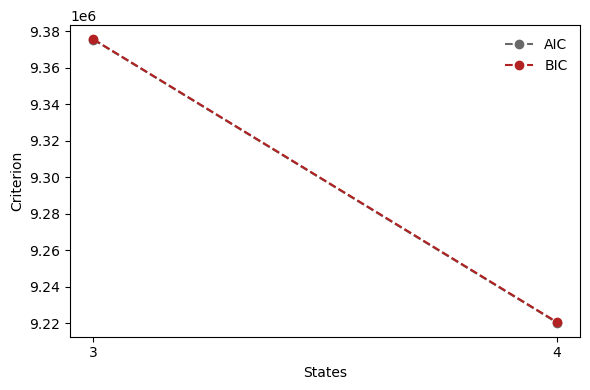

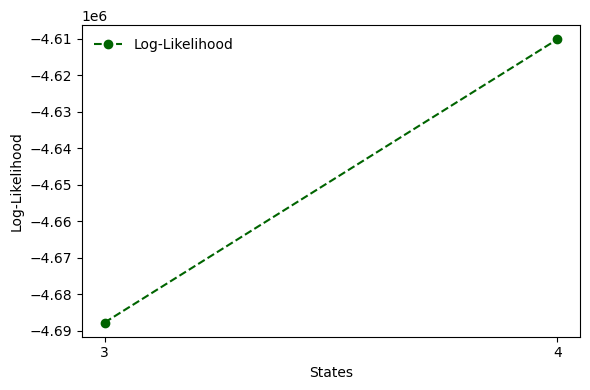

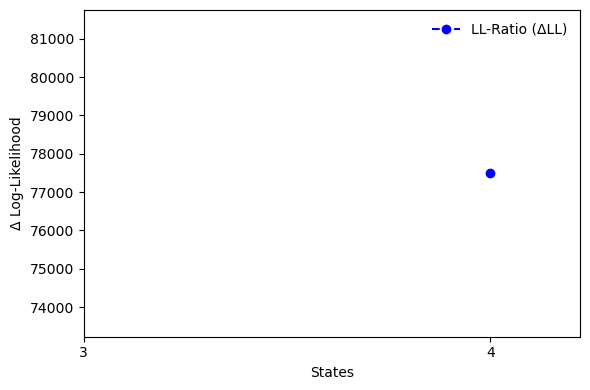

Summary saved to new_models/pdgfra_nterm_ctcfwt_models/aic_bic_ll_summary.csv
AIC values: [9375456.560836587, 9220493.990759889]
BIC values: [9375625.386311462, 9220771.346897181]
Log-likelihood values: [-4687714.280418294, -4610223.995379944]
LL ratio values: [nan, 77490.28503834922]


In [ ]:
# Example traces list
traces = [p1_bp, p2_bp, p3_bp, p4_bp]

# Run the function
results = aic_bic_hmm_states_convergence_minmax_bp(
    traces=traces,
    min_no_states=,           # minimum number of states to test
    max_no_states=4,           # maximum number of states to test
    cross_val=False,           # set True if you want k-fold CV
    n_splits=1,                # only used if cross_val=True
    convergence_threshold=0.01,
    max_iter=300,
    save_dir="new_models/pdgfra_nterm_ctcfwt_bp_models"  # where models and CSV files are saved
)

# Access returned values
print("AIC values:", results["aic"])
print("BIC values:", results["bic"])
print("Log-likelihood values:", results["ll"])
print("LL ratio values:", results["ll_ratio"])


#### PDGFRA C-term CTCF WT

In [78]:
# Example traces list
traces = [pc1_bp, pc2_bp, pc3_bp, pc4_bp]
res = fit_final_hmm(
    traces, K=4,
    n_iter=1000,
    feature_col='bp_corrected',
    save_path="final_models/bp_pdgfra_cterm_ctcfwt_4_model.pkl"
)
print(res["K"], res["log_likelihood"], res["BIC"])


         1 -4145692.62857528             +nan
         2 -3422557.29523366 +723135.33334162
         3 -3395079.58152820  +27477.71370547
         4 -3377144.53423923  +17935.04728897
         5 -3363225.21343295  +13919.32080628
         6 -3352268.58748147  +10956.62595148
         7 -3342697.48688543   +9571.10059604
         8 -3332621.84972139  +10075.63716404
         9 -3321696.99867253  +10924.85104886
        10 -3310653.71617859  +11043.28249394
        11 -3300580.13934206  +10073.57683653
        12 -3292286.66024166   +8293.47910039
        13 -3286007.25966024   +6279.40058143
        14 -3281599.35620618   +4407.90345406
        15 -3278678.36995906   +2920.98624712
        16 -3276811.14462440   +1867.22533466
        17 -3275635.62344148   +1175.52118292
        18 -3274892.06372320    +743.55971828
        19 -3274407.74400132    +484.31972188
        20 -3274071.47362332    +336.27037800
        21 -3273812.03543155    +259.43819177
        22 -3273583.93560730    +2

4 -3269638.8959651804 6539592.788791531


       151 -3269638.89687235      +0.00097826


#### PDGFRA N-term CTCF WT PDS5A

In [75]:
traces = [p5_1_bp, p5_4_bp, p5_5_bp, p5_6_bp, p5_7_bp, p5_8_bp]
res = fit_final_hmm(
    traces, K=4,
    feature_col='bp_corrected',
    n_iter=1000,
    save_path="final_models/bp_pdgfra_nterm_ctcfwt_pds5a_4_model.pkl"
)
print(res["K"], res["log_likelihood"], res["BIC"])


         1 -6444591.71033021             +nan
         2 -5499830.51404336 +944761.19628685
         3 -5479428.31220230  +20402.20184105
         4 -5474888.10322538   +4540.20897692
         5 -5473367.62087232   +1520.48235306
         6 -5472705.24038603    +662.38048629
         7 -5472367.98492858    +337.25545745
         8 -5472173.20712785    +194.77780073
         9 -5472046.30928941    +126.89783844
        10 -5471953.74222788     +92.56706154
        11 -5471879.35331082     +74.38891706
        12 -5471814.93753435     +64.41577647
        13 -5471756.15971258     +58.77782177
        14 -5471700.67304696     +55.48666562
        15 -5471647.20044046     +53.47260651
        16 -5471595.06068263     +52.13975783
        17 -5471543.90893282     +51.15174981
        18 -5471493.58667391     +50.32225891
        19 -5471444.03363954     +49.55303436
        20 -5471395.23736896     +48.79627059
        21 -5471347.20402721     +48.03334175
        22 -5471299.94439340     +

4 -5467806.052091244 10935939.908060942


#### PDGFRA N-term CTCF WT Cohesin

In [76]:
traces = [oc1_bp, oc3_bp, oc4_bp, oc5_bp, oc6_bp]
res = fit_final_hmm(
    traces, K=4,
    feature_col='bp_corrected',
    n_iter=1000,
    save_path="final_models/bp_pdgfra_nterm_ctcfwt_cohesin_4_model.pkl"
)
print(res["K"], res["log_likelihood"], res["BIC"])

         1 -8901174.45182925             +nan
         2 -7661812.98440877 +1239361.46742049
         3 -7640742.00544389  +21070.97896488
         4 -7633871.49922153   +6870.50622236
         5 -7630526.09765163   +3345.40156991
         6 -7627982.73976639   +2543.35788523
         7 -7625800.78382604   +2181.95594036
         8 -7623926.35106722   +1874.43275882
         9 -7622362.18234925   +1564.16871797
        10 -7621081.08711454   +1281.09523471
        11 -7620035.11002703   +1045.97708751
        12 -7619177.02082765    +858.08919938
        13 -7618467.68216517    +709.33866248
        14 -7617876.13244301    +591.54972217
        15 -7617378.20062874    +497.93181427
        16 -7616955.08127499    +423.11935375
        17 -7616592.12623267    +362.95504232
        18 -7616277.88656019    +314.23967248
        19 -7616003.37864560    +274.50791459
        20 -7615761.52106495    +241.85758065
        21 -7615546.70224467    +214.81882028
        22 -7615354.44994234    +

4 -7610637.551440964 15221609.777822323


#### PDGFRA N-term CTCF WT Cohesin & PDS5A

In [81]:
traces = [pc_11_bp, pc_13_bp, pc_14_bp]
res = fit_final_hmm(
    traces, K=4,
    feature_col='bp_corrected',
    n_iter=1000,
    save_path="final_models/bp_pdgfra_nterm_ctcfwt_cohesin_pds5a_4_model.pkl"
)
print(res["K"], res["log_likelihood"], res["BIC"])


         1 -3288126.42230410             +nan
         2 -2831270.32840478 +456856.09389933
         3 -2824002.75937802   +7267.56902676
         4 -2822655.73019433   +1347.02918369
         5 -2822216.14450344    +439.58569089
         6 -2821960.31380017    +255.83070328
         7 -2821752.37109826    +207.94270190
         8 -2821559.13821808    +193.23288018
         9 -2821372.63698470    +186.50123339
        10 -2821191.57349187    +181.06349282
        11 -2821016.26677161    +175.30672027
        12 -2820847.12216891    +169.14460270
        13 -2820684.28484737    +162.83732154
        14 -2820527.68872391    +156.59612346
        15 -2820377.16812707    +150.52059684
        16 -2820232.53073180    +144.63739527
        17 -2820093.58180411    +138.94892768
        18 -2819960.12918097    +133.45262314
        19 -2819831.97447921    +128.15470176
        20 -2819708.91044216    +123.06403705
        21 -2819590.71856111    +118.19188105
        22 -2819477.17183307    +1

4 -2815602.257201533 5631517.084961151


       543 -2815602.25816858      +0.00098009


### Plotting LL

In [47]:
import os, re, glob
import numpy as np
import pandas as pd

def _compute_N_from_traces(traces, col="force_corrected (pN)"):
    """Total non-NaN samples across all traces in the column used for fitting."""
    return int(np.sum([np.isfinite(t[col].values).sum() for t in traces]))

def reconstruct_hmm_summary(
    folder,
    N=None,                 # total # points used to fit; if None and traces provided, computed from traces
    traces=None,            # list of DataFrames used to fit this condition (to compute N automatically)
    D=1,                    # data dimensionality (1 for force)
    max_states=None         # optionally cap highest state included
):
    """
    Rebuild aic_bic_ll_summary.csv from 'loglikelihood_{n}_states.csv' files
    and save it to <folder>/aic_bic_ll_summary.csv. Computes BIC if N is available.
    """
    # If N not provided, try to compute from traces
    if N is None and traces is not None:
        N = _compute_N_from_traces(traces)
        print(f"[info] Computed N from traces: N = {N}")

    files = glob.glob(os.path.join(folder, "loglikelihood_*_states.csv"))
    if not files:
        raise FileNotFoundError(f"No loglikelihood CSVs found in {folder}")

    pat = re.compile(r"loglikelihood_(\d+)_states\.csv$")
    pairs = []
    for fp in files:
        m = pat.search(os.path.basename(fp))
        if m:
            n = int(m.group(1))
            if max_states is None or n <= max_states:
                pairs.append((n, fp))

    if not pairs:
        raise RuntimeError("No usable loglikelihood files found (check max_states filter).")

    pairs.sort(key=lambda x: x[0])

    rows = []
    cov_params = D * (D + 1) // 2  # full-cov params per state (for D=1 this is 1)

    for n, fp in pairs:
        df = pd.read_csv(fp)
        if "log_likelihood" not in df.columns:
            raise ValueError(f"'log_likelihood' column not found in {fp}")
        ll = float(df["log_likelihood"].iloc[-1])  # final LL after EM

        # Parameter count p = transitions + emissions - constraints
        # transitions ~ n^2, emissions per state: means (D) + cov params
        p = n**2 + n * (D + cov_params) - 1

        aic = 2 * p - 2 * ll
        bic = (np.log(N) * p - 2 * ll) if N is not None else np.nan

        rows.append({"states": n, "AIC": aic, "BIC": bic, "LogLikelihood": ll})

    rows.sort(key=lambda r: r["states"])

    # ΔLL vs previous n
    prev_ll = None
    for r in rows:
        r["LL_Ratio"] = (r["LogLikelihood"] - prev_ll) if prev_ll is not None else np.nan
        prev_ll = r["LogLikelihood"]

    summary = pd.DataFrame(rows, columns=["states", "AIC", "BIC", "LogLikelihood", "LL_Ratio"])
    outpath = os.path.join(folder, "aic_bic_ll_summary.csv")
    summary.to_csv(outpath, index=False)
    print(f"✅ Rebuilt summary written to: {outpath}")
    return summary


In [69]:
summary = reconstruct_hmm_summary(
    "new_models/pdgfra_nterm_ctcfwt_cohesin_models/",
    traces=[oc_1, oc_2, oc_3, oc_4, oc_5, oc_6, oc_7, oc_8, oc_9, oc_10, oc_11, oc_12, oc_13, oc_14, oc_15, oc_17, oc_18, oc_19, oc_20],  # the same traces you fit
    D=1,
    max_states=6
)


[info] Computed N from traces: N = 6901552
✅ Rebuilt summary written to: new_models/pdgfra_nterm_ctcfwt_cohesin_models/aic_bic_ll_summary.csv


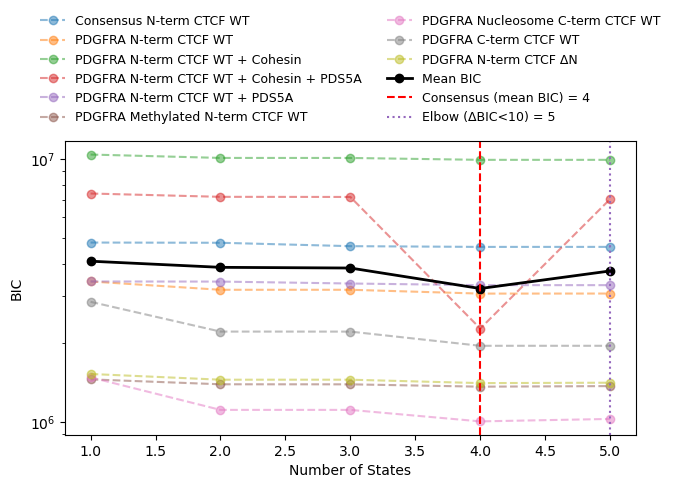

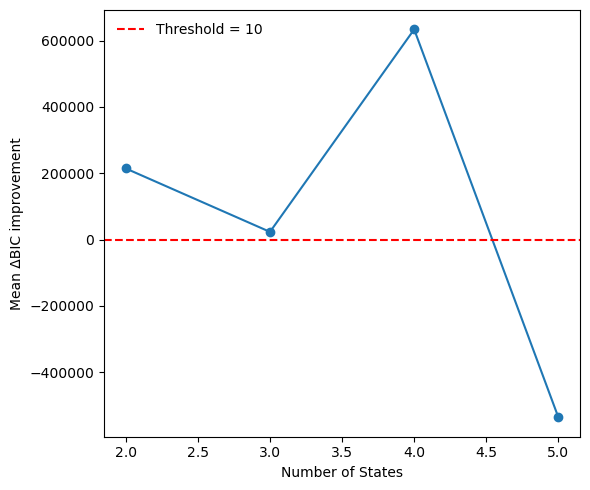

Per-condition BIC minima:
  Consensus N-term CTCF WT: 4 states
  PDGFRA N-term CTCF WT: 4 states
  PDGFRA N-term CTCF WT + Cohesin: 5 states
  PDGFRA N-term CTCF WT + Cohesin + PDS5A: 4 states
  PDGFRA N-term CTCF WT + PDS5A: 4 states
  PDGFRA Methylated N-term CTCF WT: 4 states
  PDGFRA Nucleosome C-term CTCF WT: 4 states
  PDGFRA C-term CTCF WT: 4 states
  PDGFRA N-term CTCF ΔN: 4 states

Consensus best state (mean BIC): 4 states
Elbow state (mean ΔBIC < 10): 5 states


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
ll_c = pd.read_csv('new_models/consensus_nterm_ctcfwt_models/aic_bic_ll_summary.csv')
ll_p = pd.read_csv('new_models/pdgfra_nterm_ctcfwt_models/aic_bic_ll_summary.csv')
ll_oc = pd.read_csv('new_models/pdgfra_nterm_ctcfwt_cohesin_models/aic_bic_ll_summary.csv')
ll_pc = pd.read_csv('new_models/pdgfra_nterm_ctcfwt_cohesinpds5a_models/aic_bic_ll_summary.csv')
ll_p5 = pd.read_csv('new_models/pdgfra_nterm_ctcfwt_pds5a_models/aic_bic_ll_summary.csv')
ll_m = pd.read_csv('new_models/pdgfra_methylated_nterm_ctcfwt_models/aic_bic_ll_summary.csv')
ll_n = pd.read_csv('new_models/pdgfra_nucleosome_cterm_ctcfwt_models/aic_bic_ll_summary.csv')
ll_ct = pd.read_csv('new_models/pdgfra_cterm_ctcfwt_models/aic_bic_ll_summary.csv')
ll_dn = pd.read_csv('new_models/pdgfra_nterm_ctcfdn_models/aic_bic_ll_summary.csv')

# Your loaded DataFrames
datasets = {
    "Consensus N-term CTCF WT": ll_c,
    "PDGFRA N-term CTCF WT": ll_p,
    "PDGFRA N-term CTCF WT + Cohesin": ll_oc,
    "PDGFRA N-term CTCF WT + Cohesin + PDS5A": ll_pc,
    "PDGFRA N-term CTCF WT + PDS5A": ll_p5,
    "PDGFRA Methylated N-term CTCF WT": ll_m,
    "PDGFRA Nucleosome C-term CTCF WT": ll_n,
    "PDGFRA C-term CTCF WT": ll_ct,
    "PDGFRA N-term CTCF ΔN": ll_dn,
}

MAX_STATES = 5   # cap here

def clean_df(df):
    df = df.copy()
    df["states"] = pd.to_numeric(df.get("states"), errors="coerce")
    df["BIC"]    = pd.to_numeric(df.get("BIC"),    errors="coerce")
    # Drop bad rows
    df = df.dropna(subset=["states", "BIC"])
    # Restrict to <= MAX_STATES
    df = df[df["states"] <= MAX_STATES]
    # Handle duplicates
    df = df.sort_values(["states", "BIC"]).groupby("states", as_index=False).first()
    df = df.sort_values("states")
    return df

# Collect per-condition minima and aligned BIC table
min_bics = {}
bic_tables = []
usable = {}

for name, raw in datasets.items():
    df = clean_df(raw)
    if len(df) == 0:
        print(f"[WARN] '{name}' has no usable rows after cleaning; skipping.")
        continue
    min_row = df.loc[df["BIC"].idxmin()]
    min_bics[name] = int(min_row["states"])
    usable[name] = df
    bic_tables.append(df[["states","BIC"]].set_index("states").rename(columns={"BIC": name}))

# Build outer-joined table of BIC across conditions (up to 5 states)
bic_all = pd.concat(bic_tables, axis=1).sort_index()
bic_all = bic_all[bic_all.index <= MAX_STATES]

# Mean BIC across conditions
bic_all["mean_BIC"] = bic_all.mean(axis=1, skipna=True)
consensus_state_bic = int(bic_all["mean_BIC"].idxmin())

# ΔBIC gains
gain_tables = []
for name in usable:
    s = usable[name].set_index("states")["BIC"].sort_index()
    s = s.reindex(bic_all.index)
    gain = s.shift(1) - s
    gain_tables.append(gain.rename(name))

gain_all = pd.concat(gain_tables, axis=1)
gain_all["mean_gain"] = gain_all.mean(axis=1, skipna=True)

ELBOW_THRESHOLD = 10.0
candidate_states = gain_all.index[1:]  # skip the smallest
elbow_state = None
for k in candidate_states:
    g = gain_all.loc[k, "mean_gain"]
    if pd.notnull(g) and g < ELBOW_THRESHOLD:
        elbow_state = int(k)
        break

# ---- Plots ----
plt.figure(figsize=(7,5))
for name, df in usable.items():
    plt.plot(df["states"], df["BIC"], '--o', alpha=0.5, label=name)
plt.plot(bic_all.index, bic_all["mean_BIC"], '-o', lw=2, label="Mean BIC", color='black')
plt.axvline(consensus_state_bic, color="red", linestyle="--", label=f"Consensus (mean BIC) = {consensus_state_bic}")
if elbow_state is not None:
    plt.axvline(elbow_state, color="tab:purple", linestyle=":", label=f"Elbow (ΔBIC<{ELBOW_THRESHOLD:g}) = {elbow_state}")
plt.xlabel("Number of States"); plt.ylabel("BIC")

# Legend above plot in 4 columns
plt.legend(frameon=False, fontsize=9, ncol=2, loc="lower center",
           bbox_to_anchor=(0.5, 1.02))

plt.yscale('log')
plt.tight_layout()

plt.show()

plt.figure(figsize=(6,5))
plt.plot(gain_all.index, gain_all["mean_gain"], '-o')
plt.axhline(ELBOW_THRESHOLD, linestyle='--', color='red', label=f"Threshold = {ELBOW_THRESHOLD:g}")
plt.xlabel("Number of States"); plt.ylabel("Mean ΔBIC improvement")
plt.legend(frameon=False)
plt.tight_layout()

plt.show()


# ---- Summary ----
print("Per-condition BIC minima:")
for cond, state in min_bics.items():
    print(f"  {cond}: {state} states")

print(f"\nConsensus best state (mean BIC): {consensus_state_bic} states")
if elbow_state is not None:
    print(f"Elbow state (mean ΔBIC < {ELBOW_THRESHOLD:g}): {elbow_state} states")
else:
    print(f"No elbow found with ΔBIC < {ELBOW_THRESHOLD:g} within {MAX_STATES} states.")


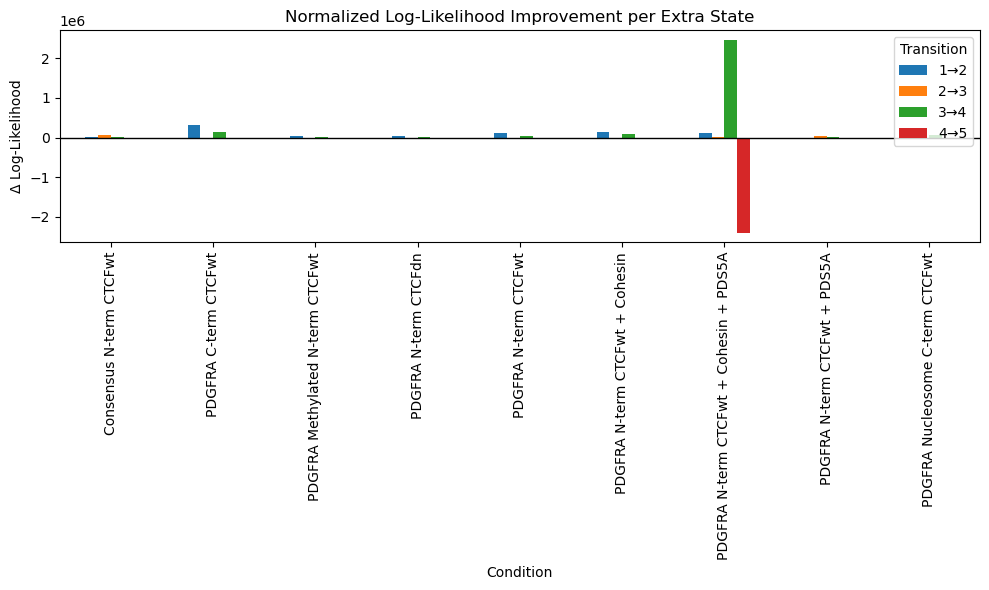

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Your files
datasets = {
    "Consensus N-term CTCFwt": "new_models/consensus_nterm_ctcfwt_models/aic_bic_ll_summary.csv",
    "PDGFRA N-term CTCFwt": "new_models/pdgfra_nterm_ctcfwt_models/aic_bic_ll_summary.csv",
    "PDGFRA N-term CTCFwt + Cohesin": "new_models/pdgfra_nterm_ctcfwt_cohesin_models/aic_bic_ll_summary.csv",
    "PDGFRA N-term CTCFwt + Cohesin + PDS5A": "new_models/pdgfra_nterm_ctcfwt_cohesinpds5a_models/aic_bic_ll_summary.csv",
    "PDGFRA N-term CTCFwt + PDS5A": "new_models/pdgfra_nterm_ctcfwt_pds5a_models/aic_bic_ll_summary.csv",
    "PDGFRA Methylated N-term CTCFwt": "new_models/pdgfra_methylated_nterm_ctcfwt_models/aic_bic_ll_summary.csv",
    "PDGFRA Nucleosome C-term CTCFwt": "new_models/pdgfra_nucleosome_cterm_ctcfwt_models/aic_bic_ll_summary.csv",
    "PDGFRA C-term CTCFwt": "new_models/pdgfra_cterm_ctcfwt_models/aic_bic_ll_summary.csv",
    "PDGFRA N-term CTCFdn": "new_models/pdgfra_nterm_ctcfdn_models/aic_bic_ll_summary.csv",
}
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_ll_gains_normalized(datasets, traces_dict=None, col="force_corrected (pN)", max_states=5):
    gains = []
    for name, path in datasets.items():
        df = pd.read_csv(path).sort_values("states")
        df = df[df["states"] <= max_states]

        # Compute N = number of non-NaN datapoints
        if traces_dict and name in traces_dict:
            N = int(np.sum([np.isfinite(t[col].values).sum() for t in traces_dict[name]]))
        else:
            # Fallback: assume BIC was computed with correct N and derive from formula?
            # For now, leave N unknown -> no normalization
            N = None

        for i in range(1, len(df)):
            s_prev, s_now = int(df.iloc[i-1]["states"]), int(df.iloc[i]["states"])
            ll_prev, ll_now = df.iloc[i-1]["LogLikelihood"], df.iloc[i]["LogLikelihood"]
            dLL = ll_now - ll_prev
            if N:
                dLL /= N
            gains.append({
                "Condition": name,
                "Transition": f"{s_prev}→{s_now}",
                "ΔLL_per_point" if N else "ΔLL": dLL
            })
    gains_df = pd.DataFrame(gains)

    # Wide pivot for nicer plotting
    pivot = gains_df.pivot(index="Condition", columns="Transition", values=gains_df.columns[-1])

    pivot.plot(kind="bar", figsize=(10,6))
    plt.ylabel("Δ Log-Likelihood per datapoint" if traces_dict else "Δ Log-Likelihood")
    plt.title("Normalized Log-Likelihood Improvement per Extra State")
    plt.axhline(0, color="black", lw=1)
    plt.tight_layout()
    plt.show()

# Example usage
plot_ll_gains_normalized(datasets)



In [70]:
# Load the summary for the Cohesin condition
df = pd.read_csv("new_models/pdgfra_nterm_ctcfwt_cohesin_models/aic_bic_ll_summary.csv")

# Get values for 4 and 5 states
bic4, bic5 = df.loc[df["states"]==4, "BIC"].values[0], df.loc[df["states"]==5, "BIC"].values[0]
ll4, ll5   = df.loc[df["states"]==4, "LogLikelihood"].values[0], df.loc[df["states"]==5, "LogLikelihood"].values[0]

print(f"ΔBIC (4→5) = {bic4 - bic5:.2f}")
print(f"ΔLL  (4→5) = {ll5 - ll4:.2f}")


ΔBIC (4→5) = 136.45
ΔLL  (4→5) = 154.84


In [76]:
import os, glob, joblib, numpy as np, pandas as pd

def concat_X(traces, col="force_corrected (pN)"):
    x = np.concatenate([t[col].values for t in traces])
    return x[np.isfinite(x)].reshape(-1,1)

def rebuild_summary_from_models(folder, traces, D=1, max_states=6, col="force_corrected (pN)"):
    X = concat_X(traces, col)
    N = X.shape[0]
    cov_params = D*(D+1)//2

    rows = []
    for n in range(1, max_states+1):
        path = os.path.join(folder, f"model_{n}_states.pkl")
        if not os.path.exists(path):
            continue
        model = joblib.load(path)
        ll = float(model.score(X))  # uniform definition of LL

        p = n**2 + n*(D + cov_params) - 1
        aic = 2*p - 2*ll
        bic = np.log(N)*p - 2*ll

        rows.append(dict(states=n, AIC=aic, BIC=bic, LogLikelihood=ll))

    rows.sort(key=lambda r: r["states"])
    prev = None
    for r in rows:
        r["LL_Ratio"] = (r["LogLikelihood"] - prev) if prev is not None else np.nan
        prev = r["LogLikelihood"]

    out = pd.DataFrame(rows, columns=["states","AIC","BIC","LogLikelihood","LL_Ratio"])
    out.to_csv(os.path.join(folder, "aic_bic_ll_summary.csv"), index=False)
    return out
